<a href="https://colab.research.google.com/github/crcastroc/Automatic-segmentation-of-collective-violence-with-metrics---NB/blob/main/Robust_Characterization_and_Segmentation_with_NB_Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ruptures

# Segmentation of Periods of Violence Severity in Internal Armed Conflicts (IAC): A Case Study of Colombia

This notebook implements and reproduces the procedure proposed to obtain segments of violence severity in an IAC. Different time series reporting the number of monthly victims are used to quantify the severity of the conflict, including series linked to other motivations, number of cases and victims, and normalized or not by the population.

For the analysis, the following steps are used:

1. A test of homogeneity is used to study the absence or presence of at least one break point in the time series.

2. A non-parametric change point detection method is used to construct a first delimitation of the conflict using multiple segments.

3. For each segment, different models previously used to explain the impacts of war were compared. These models include heavy-tail, Gaussian, and Poisson. Results are compared with the negative binomial distribution, which explains the overdispersion observed in the series and has not been previously explored in this domain.

4. A novel segmentation strategy aimed to determine segments that follow negative bimonial is used to determine segments constituting the conflict.

In [ ]:
import pandas as pd
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Path of the file
file_path = '/content/drive/My Drive/ViolenceSegmentation/monthlyViolenceColombia.xlsx'
path_images = '/content/drive/My Drive/ViolenceSegmentation/images'

df = pd.read_excel(file_path, sheet_name="violence_indicators")
dfDataOrig = df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import display, HTML

# Set the indicator of violence
idIndicatorViolenceList = [
    'Victims of collective violence','Victims of indiscriminate violence','Victims of selective violence',
    'Cases of collective violence','Cases of indiscriminate violence','Cases of selective violence']

idIndicatorViolenceList = ['Cases of selective violence']



for idIndicatorViolence in idIndicatorViolenceList:
  print('\n\nIndicator of violence: '+idIndicatorViolence)
  df['month'] = pd.to_datetime(df['period'], format='%Y/%m')
  # Get the minimum and maximum dates
  start_date = df['month'].min()
  end_date = df['month'].max()
  print(f"The time period goes from {start_date.strftime('%Y-%m')} to {end_date.strftime('%Y-%m')}")
  html = df[idIndicatorViolence].head().to_frame().to_html(index=True)
  display(HTML(html))



Indicator of violence: Cases of selective violence
The time period goes from 1958-01 to 2021-12


,Cases of selective violence
0,37
1,20
2,29
3,17
4,3


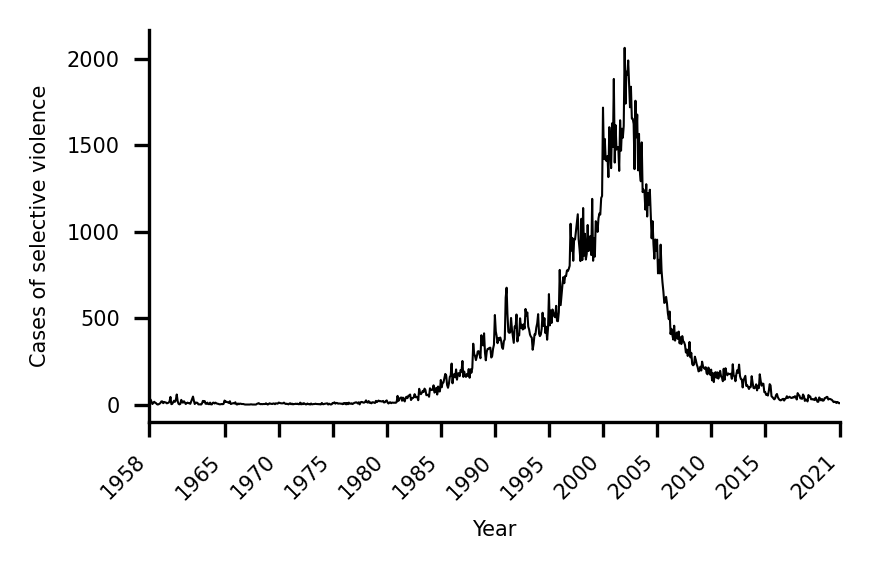

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator
from typing import List

from __future__ import annotations
import numpy as np
import math
from typing import Dict, Any, Optional, Tuple
from pathlib import Path
from typing import List, Tuple

# ---------- Low-level utilities ----------
def _save_figure(fig, out_dir: str | Path, base: str,
                 formats=("pdf", "svg", "png"), dpi=600, transparent=False):
    """
    Save a Matplotlib figure in multiple formats for publication.
    - PDF/SVG are vector (best for journals); PNG is a high-DPI raster fallback.
    - dpi only affects raster formats (PNG).
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    saved = []
    for fmt in formats:
        fname = out_dir / f"{base}.{fmt.lower()}"
        if fmt.lower() == "png":
            fig.savefig(fname, dpi=dpi, bbox_inches="tight", transparent=transparent)
        else:
            fig.savefig(fname, bbox_inches="tight", transparent=transparent)
        saved.append(str(fname))
    return saved



import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator

# -----------------------------
# 1) Compute reusable ticks
# -----------------------------
def compute_time_ticks(start_dt: pd.Timestamp,
                       end_dt: pd.Timestamp,
                       year_interval: int = 5,
                       include_edges: bool = True,
                       drop_first_after_start: bool = True,
                       drop_last_before_end: bool = True) -> list[pd.Timestamp]:
    """Compute YYYY/01 ticks every `year_interval` years strictly within [start_dt, end_dt]."""
    if not isinstance(start_dt, pd.Timestamp):
        start_dt = pd.to_datetime(start_dt)
    if not isinstance(end_dt, pd.Timestamp):
        end_dt = pd.to_datetime(end_dt)
    if start_dt > end_dt:
        start_dt, end_dt = end_dt, start_dt

    base_year = (start_dt.year // year_interval) * year_interval
    first_jan = pd.Timestamp(year=base_year, month=1, day=1)
    if first_jan < start_dt.normalize():
        first_jan = pd.Timestamp(year=base_year + year_interval, month=1, day=1)

    anchors = pd.date_range(start=first_jan, end=end_dt, freq=f'{year_interval}YS')
    ticks = list(anchors)

    if include_edges:
        ticks.append(start_dt)
        ticks.append(end_dt)

    ticks = sorted({t for t in ticks if start_dt <= t <= end_dt})

    # Drop first tick after start
    if drop_first_after_start and len(ticks) > 2:
        for i, t in enumerate(ticks):
            if t > start_dt:
                ticks.pop(i)
                break

    # Drop last tick before end
    if drop_last_before_end and len(ticks) > 2:
        for i in range(len(ticks) - 1, -1, -1):
            if ticks[i] < end_dt:
                ticks.pop(i)
                break

    return ticks


# -----------------------------
# 2) Apply ticks to any Axes
# -----------------------------
def apply_time_ticks(ax,
                     ticks: list[pd.Timestamp],
                     fmt: str = '%Y/%m',
                     rotation: int = 45,
                     ha: str = 'right',
                     font_size: int = 8):
    """Apply precomputed datetime ticks to a Matplotlib Axes with smaller fonts."""
    ax.xaxis.set_major_locator(FixedLocator([mdates.date2num(t) for t in ticks]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.setp(ax.get_xticklabels(), rotation=rotation, ha=ha, fontsize=font_size)


# -----------------------------
# 3) Plotting function with font scaling
# -----------------------------
def plot_indicator_ts(df: pd.DataFrame,
                      date_col: str,
                      value_col: str,
                      title: str | None = None,
                      save_path: str | None = None,
                      year_interval: int = 5,
                      figsize: tuple = (7.2, 3.6),
                      font_scale: float = 0.9,
                      line_width: float = 0.9,
                      color_line: str | None = None,):
    """
    Plot a monthly time series in journal style.
    Uses compute_time_ticks() for consistent x-axis ticks.
    Fonts are scaled by `font_scale`.
    """

    data = df[[date_col, value_col]].copy()

    # Ensure datetime
    if not pd.api.types.is_datetime64_any_dtype(data[date_col]):
        data[date_col] = pd.to_datetime(data[date_col], format='%Y/%m', errors='coerce')

    data = data.dropna(subset=[date_col, value_col]).sort_values(date_col)
    if data.empty:
        raise ValueError("No valid rows after parsing dates/values.")

    start_dt = data[date_col].iloc[0]
    end_dt   = data[date_col].iloc[-1]

    # Base font size scales with figure size and font_scale
    base_font = max(3, int(min(figsize) * 1.2 * font_scale))

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    ax.plot(data[date_col], data[value_col], color=color_line, linewidth=line_width)

    # Minimal journal-style axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)

    ax.set_xlim(start_dt, end_dt)

    # Compute & apply ticks
    ticks = compute_time_ticks(start_dt, end_dt,
                               year_interval=year_interval,
                               include_edges=True,
                               drop_first_after_start=True,
                               drop_last_before_end=True)
    apply_time_ticks(ax, ticks, fmt='%Y', rotation=45, ha='right', font_size=base_font)

    # Labels and title with smaller fonts
    ax.set_xlabel('Year', fontsize=base_font)
    ax.set_ylabel(title, fontsize=base_font)

    # Scale tick labels for Y axis too
    ax.tick_params(axis='y', labelsize=base_font)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    saved_paths = _save_figure(fig, path_images, title, formats=("png",))
    return ax


violence_colors = {
    # Collective violence: darker tones to emphasize severity
    "Cases of collective violence": "#1B7F79",     # medium-dark teal
    "Victims of collective violence": "#004D40",   # dark forest green

    # Indiscriminate violence: lighter tones for chaotic/unfocused attacks
    "Cases of indiscriminate violence": "#FFD580",   # light pastel orange
    "Victims of indiscriminate violence": "#FF9933", # warm light vermillion

    # Selective violence: medium tones, calm but targeted
    "Cases of selective violence": "#6AAED6",      # medium-light blue
    "Victims of selective violence": "#1F78B4",    # deeper blue
}

violence_colors = {
    # Collective violence: darker tones to emphasize severity
    "Cases of collective violence": "black",     # medium-dark teal
    "Victims of collective violence": "black",   # dark forest green

    # Indiscriminate violence: lighter tones for chaotic/unfocused attacks
    "Cases of indiscriminate violence": "black",   # light pastel orange
    "Victims of indiscriminate violence": "black", # warm light vermillion

    # Selective violence: medium tones, calm but targeted
    "Cases of selective violence": "black",      # medium-light blue
    "Victims of selective violence": "black",    # deeper blue
}



for idIndicatorViolence in idIndicatorViolenceList:
  plot_indicator_ts(
      df,
      date_col='period',
      value_col=idIndicatorViolence,
      title=idIndicatorViolence,
      figsize=(3,2),
      font_scale=2.2,
      line_width=0.5,
      color_line=violence_colors[idIndicatorViolence]
  )

# Homogeneity Test based on a Weighted Kolmogorov–Smirnov Statistic

The **homogeneity test** based on the **Weighted Kolmogorov–Smirnov (KS)** statistic is used to determine whether a sequence of data comes from a **single, stable distribution** (**homogeneity**) or whether there is evidence of a **structural change** at some point.

- **Null hypothesis** $H_0$:  
  All observations come from the same distribution → **no change**.
- **Alternative hypothesis** $H_1$:  
  There exists at least one **change-point** $\tau$, where the underlying distribution changes.

In this case we are interested in studying the existence of at least one change point, i.e., the underlying distribution changes

---

Given a dataset $\{x_1, x_2, \dots, x_n\}$, the Weighted KS is computed using the followin procedure:

1. Define candidate split points. Choose a range of possible split points $t$, for example $t \in \{t_{\min}, \dots, t_{\max}\}$. It is common to exclude extreme values so that each segment has enough observations.

2. Compute the classical KS distance. For each candidate split $t$, divide the data into two segments:
  - Left: $\{x_1, \dots, x_t\}$
  - Right: $\{x_{t+1}, \dots, x_n\}$

3. Calculate the classical two-sample KS statistic:

$$
D(t) = \sup_x \, \big| F_1(x; t) - F_2(x; t) \big|,
$$

where, $F_1$ is the empirical Cumulative Distribution Function (CD)F of the left block and $F_2$ is the empirical CDF of the right block.

4. Apply weighting to correct imbalance. The classical KS statistic tends to overestimate discrepancies when one segment is much smaller.  To stabilize the variance, we use the Weighted KS statistic:

$$
W(t) = \sqrt{ \frac{n}{t(n-t)} } \cdot D(t),
$$

where $n$: total number of observations $t$ is candidate split index and $D(t)$ is the classical KS distance.

5. Define the global test statistic. The test statistic is the maximum weighted discrepancy:

$$
T_n = \max_{t \in \mathcal{T}} W(t),
$$

and the **candidate change-point** is:

$$
t^* = \arg\max_{t} W(t)
$$

6. Estimate a p-value. Once $T_n$ is computed an estimated p-value can be computed using permutation-based approach, which consist in:
     - Shuffle the data randomly $B$ times.
     - Recalculate $T_n^{(b)}$ for each permutation.
     - Approximate the p-value:

$$
p = \frac{1 + \#\{b : T_n^{(b)} \ge T_n\}}{B + 1}
$$

7. Decision rule:
   - If $p < \alpha$: reject $H_0$ → **heterogeneity detected**.
   - If $p \ge \alpha$: fail to reject $H_0$ → **homogeneity plausible**.



## **6. Visualization: Monitoring Plot**

A **monitoring plot** is a useful diagnostic tool:

- **X-axis**: candidate split points $t$.
- **Y-axis**: values of $W(t)$.
- Add a dashed line representing a **critical threshold** (e.g., 95th percentile under the null).

If $W(t)$ exceeds the threshold in a region, this suggests a likely change-point.

---

## **7. Summary**

- **What it does**: tests whether a sequence is homogeneous or has a significant change.
- **How it works**: compares left and right segments using the **weighted** KS statistic.
- **Outputs**:
  - $T_n$: maximum weighted discrepancy.
  - $t^*$: likely location of the change.
  - $p$-value: statistical significance.


Tn (max W): 12.3441
t* (argmax): 276
Permutation p-value: 0.0909


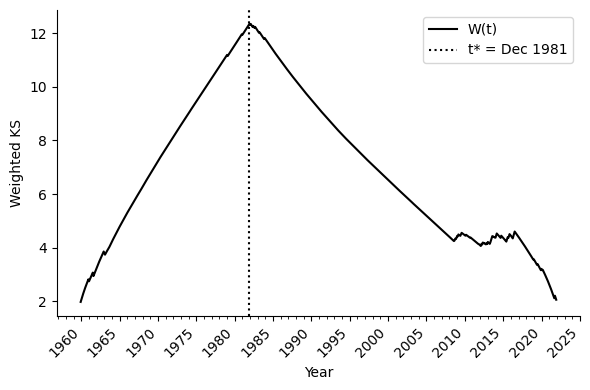

In [ ]:
# weighted_ks_homogeneity_test.py
# -------------------------------------------------------------
# Weighted (Cunen–Hermansen–Hjort-style) KS homogeneity test:
# - Scans candidate split points t and computes W(t) = sqrt(n / (t*(n-t))) * D(t)
# - Uses a permutation null (optionally with block permutation) to get a p-value
# - Provides monitoring plot and Tn null histogram helpers
#
# Dependencies: numpy, matplotlib (for plots; optional)
# SciPy is NOT required.
# -------------------------------------------------------------

from __future__ import annotations
import numpy as np
import math
from typing import Dict, Any, Optional, Tuple
from pathlib import Path
from typing import List, Tuple

def advance_month_year(year_start: int, month_start: int, skipWindowSize: int):
    # Compute absolute number of months since year 0
    total_months = (year_start * 12 + (month_start - 1)) + skipWindowSize

    # Compute new year and month
    new_year = total_months // 12
    new_month = (total_months % 12) + 1

    return new_year, new_month

def _ecdf(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return sorted data and ECDF values."""
    xs = np.sort(x)
    n = xs.size
    ys = np.arange(1, n + 1) / n
    return xs, ys

def _ks_distance(x: np.ndarray, y: np.ndarray) -> float:
    """
    Two-sample KS distance D = sup_x |F_x - F_y| using ECDFs on a merged support grid.
    Pure NumPy implementation (no SciPy).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    # Handle degenerate cases
    if x.size == 0 or y.size == 0:
        return 0.0
    grid = np.sort(np.unique(np.concatenate([x, y])))
    xs, Fx = _ecdf(x)
    ys, Fy = _ecdf(y)
    Fx_at = np.searchsorted(xs, grid, side="right") / x.size
    Fy_at = np.searchsorted(ys, grid, side="right") / y.size
    return float(np.max(np.abs(Fx_at - Fy_at)))

# ---------- Core scan ----------

def weighted_ks_scan(
    data: np.ndarray,
    t_min: int = 5,
    t_max: Optional[int] = None
) -> Dict[str, Any]:
    """
    Compute the weighted KS scan across candidate splits t in [t_min, t_max].
    Weight: sqrt(n / (t*(n-t))) times the two-sample KS distance.
    Returns a dict with arrays for t, D(t), W(t), and the max statistic info.
    """
    x = np.asarray(data, dtype=float)
    n = x.size
    if n < 3:
        raise ValueError("Data must have at least 3 points.")
    if t_max is None:
        t_max = n - max(5, t_min)
    if not (1 <= t_min < t_max < n):
        raise ValueError("Require 1 <= t_min < t_max < n and both sides non-empty.")

    ts = np.arange(t_min, t_max + 1)
    D_vals = np.empty(ts.size, dtype=float)
    W_vals = np.empty(ts.size, dtype=float)

    for i, t in enumerate(ts):
        left = x[:t]
        right = x[t:]
        D_t = _ks_distance(left, right)
        w = math.sqrt((t * (n - t)/n))
        D_vals[i] = D_t
        W_vals[i] = w * D_t




    idx_max = int(np.argmax(W_vals))
    return {
        "t_grid": ts,
        "D": D_vals,
        "W": W_vals,
        "Tn": float(W_vals[idx_max]),
        "t_star": int(ts[idx_max]),
        "n": int(n)
    }

# ---------- Permutation utilities ----------

def _permute_series(
    y: np.ndarray,
    rng: np.random.Generator,
    block_len: Optional[int] = None
) -> np.ndarray:
    """
    Permute y to approximate the null of homogeneity.
    If block_len is None -> full random permutation (i.i.d. null).
    If block_len is an integer -> non-overlapping block permutation to preserve short-range dependence.
    """
    y = np.asarray(y)
    n = y.size
    if block_len is None:
        return y[rng.permutation(n)]

    L = int(block_len)
    if L <= 0:
        raise ValueError("block_len must be a positive integer.")
    m = n // L
    if m == 0:
        # If blocks are longer than the series, fallback to full permutation
        return y[rng.permutation(n)]

    core = y[: m * L].reshape(m, L)
    idx = rng.permutation(m)
    y_perm = core[idx].reshape(-1)
    # Append the leftover tail as-is (or you could also randomly permute the tail only)
    if m * L < n:
        y_perm = np.concatenate([y_perm, y[m * L :]])
    return y_perm

# ---------- Homogeneity test with permutation p-value ----------

def weighted_ks_homogeneity_test(
    data: np.ndarray,
    t_min: int = 5,
    t_max: Optional[int] = None,
    n_perm: int = 1000,
    random_state: Optional[int] = None,
    block_len: Optional[int] = None,
    return_pointwise_crit: bool = False,
    crit_alpha: float = 0.95
) -> Dict[str, Any]:
    """
    Homogeneity test using Tn = max_t W(t) and a permutation-based null.

    Parameters
    ----------
    data : array-like
        1D numeric series.
    t_min, t_max : int or None
        Bounds for candidate split points (inclusive). Exclude small edges.
    n_perm : int
        Number of permutations for the null.
    random_state : int or None
        Seed for reproducibility.
    block_len : int or None
        If provided, uses block permutation with this block length to preserve dependence.
    return_pointwise_crit : bool
        If True, also return a pointwise (over t) critical curve for W(t) under the null
        (useful for a monitoring plot). Note: this is not a global threshold.
    crit_alpha : float
        Quantile for the pointwise critical curve (e.g., 0.95).

    Returns
    -------
    dict with keys:
        scan: dict of arrays (t_grid, D, W, Tn, t_star, n)
        p_value: float
        Tn_null: array of null Tn values (length n_perm)
        crit_curve: np.ndarray of shape (len(t_grid),) if return_pointwise_crit else None
    """
    rng = np.random.default_rng(random_state)
    x = np.asarray(data, dtype=float)
    scan = weighted_ks_scan(x, t_min=t_min, t_max=t_max)
    ts = scan["t_grid"]
    n = scan["n"]
    Tn_obs = scan["Tn"]

    Tn_null = np.empty(n_perm, dtype=float)
    W_null_mat = None
    if return_pointwise_crit:
        W_null_mat = np.empty((n_perm, ts.size), dtype=float)

    for b in range(n_perm):
        x_perm = _permute_series(x, rng=rng, block_len=block_len)
        res_b = weighted_ks_scan(x_perm, t_min=t_min, t_max=t_max)
        Tn_null[b] = res_b["Tn"]
        if return_pointwise_crit:
            W_null_mat[b, :] = res_b["W"]

    # Add-one smoothing to avoid zero p-values
    p_val = float((1 + np.sum(Tn_null >= Tn_obs)) / (n_perm + 1))

    crit_curve = None
    if return_pointwise_crit and W_null_mat is not None:
        crit_curve = np.quantile(W_null_mat, crit_alpha, axis=0)

    return {
        "scan": scan,
        "p_value": p_val,
        "Tn_null": Tn_null,
        "crit_curve": crit_curve
    }

# ---------- Plotting helpers (matplotlib; optional) ----------
def plot_monitoring(
    results: Dict[str, Any],
    month_start: int,
    year_start: int,
    title: str = "Weighted KS Monitoring Plot",
    pathDir: str = "",
    nameFile: str = ""
) -> None:
    """
    Plot W(t) and optional pointwise critical curve; mark t* (argmax).
    X-axis shows month-year labels based on month_start and year_start.
    Major ticks every 5 years, minor ticks every 1 year.
    Removes top/right spines for a cleaner look.
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd

    scan = results["scan"]
    ts = scan["t_grid"]
    W = scan["W"]
    t_star = scan["t_star"]
    crit = results.get("crit_curve", None)
    n = scan["n"]

    # Create monthly datetime index starting from month_start and year_start
    date_range = pd.date_range(
        start=pd.Timestamp(year=year_start, month=month_start, day=1),
        periods=n,
        freq="MS"
    )

    # Map t values to actual dates
    dates = date_range[ts - 1]
    t_star_date = date_range[t_star - 1]

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot W(t)
    ax.plot(dates, W, label="W(t)", color="black")

    # Plot critical curve if available
    if crit is not None:
        ax.plot(dates, crit, linestyle="--", color="gray", label="Pointwise critical (null)")

    # Mark t*
    ax.axvline(t_star_date, linestyle=":", color="black",
               label=f"t* = {t_star_date.strftime('%b %Y')}")

    # Set x-axis ticks: major every 5 years, minor every year
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))   # major ticks every 5 years
    ax.xaxis.set_minor_locator(mdates.YearLocator())         # minor ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate(rotation=45)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Labels & legend
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Weighted KS")
    ax.legend()
    plt.tight_layout()
    plt.show()

    saved_paths = _save_figure(fig, path_images, nameFile, formats=("png",))


def plot_Tn_null(
    results: Dict[str, Any],
    title: str = "Null distribution of Tn (permutation)"
) -> None:
    """
    Plot histogram of null Tn and the observed Tn.
    """
    import matplotlib.pyplot as plt

    Tn_null = results["Tn_null"]
    Tn = results["scan"]["Tn"]

    plt.figure()
    plt.hist(Tn_null, bins=30, density=True, alpha=0.7)
    plt.axvline(Tn, linestyle="--", label=f"Observed Tn = {Tn:.3f}")
    plt.title(title)
    plt.xlabel("Tn")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()
    saved_paths = _save_figure(fig, path_images,'ks_index', formats=("png",))


def runHomogeneityTest(x, nperm=1000, skipWindowSize=12,
                       month_start=1, year_start=2010,pathDir: str = "",nameFile: str = ""):
    x = np.asarray(x, dtype=float)
    n = len(x)

    results = weighted_ks_homogeneity_test(
        x,
        t_min=skipWindowSize,
        t_max=n - skipWindowSize,
        n_perm=nperm,
        random_state=2025,
        block_len=None,
        return_pointwise_crit=False,
        crit_alpha=0.95
    )

    (year_startWt,month_startWt) = advance_month_year(year_start,month_start, skipWindowSize)

    print(f"Tn (max W): {results['scan']['Tn']:.4f}")
    print(f"t* (argmax): {results['scan']['t_star']}")
    print(f"Permutation p-value: {results['p_value']:.4f}")

    plot_monitoring(results, month_startWt, year_startWt,"",pathDir,nameFile)
    #plot_Tn_null(results, title="Null Distribution of Tn")


#
x = df[idIndicatorViolence].values
n = len(x)
# Run the Kolmogorov-Smirnov homogenetity test the violence impact time series
nperm  = 10
skipWindowSize = 12
yearStart = 1958
monthStart = 1
runHomogeneityTest(x,nperm,skipWindowSize,monthStart,yearStart,".","ks_stat")

In [ ]:
import os, glob
print(os.getcwd())
print(glob.glob("./segments_kde*"))

/content
['./segments_kde.png']


In [ ]:
df.head()

,period,Cases of collective violence,Cases of indiscriminate violence,Cases of selective violence,Victims of collective violence,Victims of indiscriminate violence,Victims of selective violence,month
0,1958/01,40,3,37,104,8,96,1958-01-01
1,1958/02,22,2,20,84,11,73,1958-02-01
2,1958/03,37,8,29,98,53,45,1958-03-01
3,1958/04,23,6,17,53,24,29,1958-04-01
4,1958/05,7,4,3,27,9,18,1958-05-01


# Non-Parametric Change-Point Detection with Multiple Breakpoints

Recall tthat there is a sequence of data points:

$$
\{x_1, x_2, \dots, x_n\}, \quad x_i \in \mathbb{R}
$$

We want to detect multiple change-points or break-points:

$$
\tau_1^*, \tau_2^*, \dots, \tau_K^*
$$

such that the distribution of the data changes at these locations.

Formally, we assume a **piecewise stationary model**:

$$
x_i \sim
\begin{cases}
P_1, & 1 \le i \le \tau_1^* \\
P_2, & \tau_1^* + 1 \le i \le \tau_2^* \\
\vdots \\
P_{K+1}, & \tau_K^* + 1 \le i \le n
\end{cases}
$$

where each segment may follow its own distribution $P_k$  
(which may differ in mean, variance, or shape).

In order to define the break-points a cost function for one segment $s = \{x_a,\dots,x_b\}$ can be defined by using the kernel similarity cost as follows:

$$
C(a,b) = \frac{1}{(b-a+1)^2} \sum_{i=a}^b \sum_{j=a}^b k(x_i, x_j),
$$

where $k(\cdot,\cdot)$ is a positive-definite kernel, e.g. the RBF kernel:

$$
k(x_i,x_j) = \exp\!\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right),
$$

Note that $C(a,b)$ measures the average similarity between poinst inside the segment. When $C(a,b)$ is high observations in the segment are homogeneous, therefore, points likely belong from the same distribution. In contrast, when there is a *Low $C(a,b)$* the segment is and possibly contains a change-point.

When $K$ breakpoints are need $\{\tau_1,\dots,\tau_K\}$, then the dataset is partitioned into $K+1$ segments:

$$
[1,\tau_1],\ [\tau_1+1,\tau_2],\ \dots,\ [\tau_K+1,n]
$$

The total cost is the sum of per-segment costs:

$$
J(\tau_1,\dots,\tau_K)
= - \sum_{k=0}^{K} C(\tau_k+1,\ \tau_{k+1}),
$$

where $\tau_0 = 0$ and $\tau_{K+1} = n$. The minus sign is added for maximizing similarity, which is equivalent to minimizing the total cost.

If the number of breakpoints $K$ is known, the optimization problem is:

$$
\{\tau_1^*, \dots, \tau_K^*\}
= \arg\min_{\tau_1,\dots,\tau_K} J(\tau_1,\dots,\tau_K).
$$

When $K$ is unknown, it is possible to balance fit and model complexity:

$$
\{\tau_1^*, \dots, \tau_{\hat K}^*\}
= \arg\min_{\tau_1,\dots,\tau_K} \Big( J(\tau_1,\dots,\tau_K) + \lambda K \Big),
$$

where $\lambda$ is a penalty controlling the number of detected breakpoints. Larger $\lambda$ resulst in fewer segments.

This minimization optimization problem can be globally using PELT (Pruned Exact Linear Time) with a complexity of $\mathcal{O}(n)$ to $\mathcal{O}(n^2)$ depending on kernel cost.


### Elbow method — geometric & second-difference intuition

In order to select the number of segments we will use the Elbow method. For this, let $C(K)$ be the total within-segment cost when using $K$ breakpoints. As $K$ increases, the model becomes more flexible and $C(K)$ typically decreases, but with diminishing returns, and adding more points does not improve the cost, instead may result in overfitting. Therefore, we can choose $K^*$ at the “bend” where adding another breakpoint barely reduces $C(K)$ in practice. This corresponds to the largest discrete second difference $\Delta^2 C(K)$, which can be defined as:

$$\Delta^2 C(K) = C(K+1) - 2\,C(K) + C(K-1)$$

This measures how quickly those improvements are **shrinking** as you keep adding breakpoints.

Therefore, on a decreasing, roughly convex cost curve, the elbow is chosen as  
  $$K^* = \arg\max_{K} \; \Delta^2 C(K),$$

i.e., the point where the slope becomes less negative the fastest. Beyond $K^*$, each extra breakpoint yields only small additional reduction in cost.


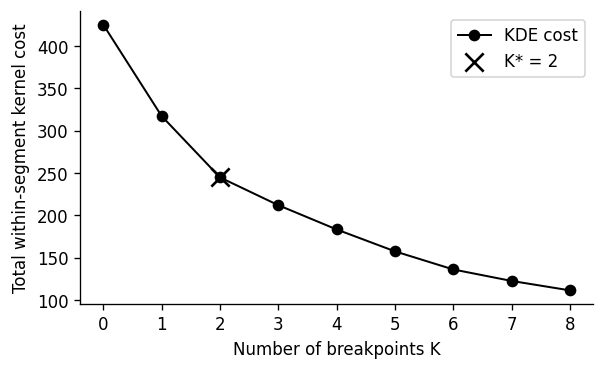

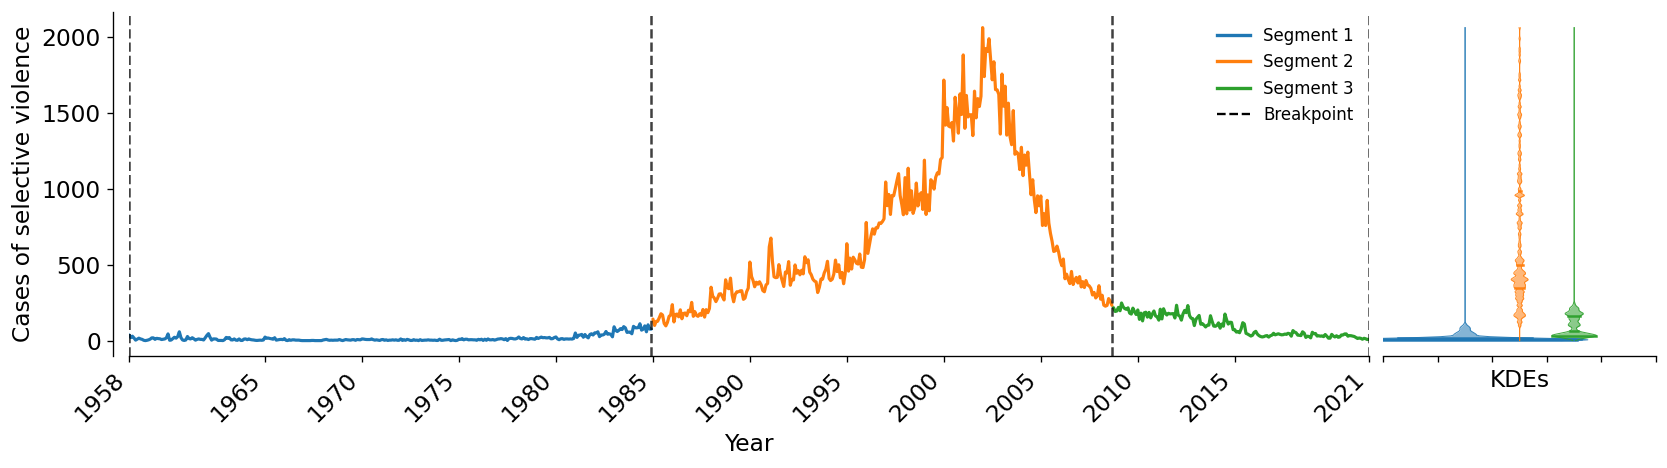

In [ ]:
# Minimal nonparametric segmentation + ONLY the last two plots:
# 1) Cost vs K (with legend, black-only, minimal axes)
# 2) Monthly series (left) + right-side KDE violins (right)

from __future__ import annotations
import numpy as np
from typing import List, Tuple

import ruptures as rpt
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors, colormaps
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neighbors import KernelDensity
from datetime import date

# ---------------- Helpers used by the core + plots ----------------

def _segments_from_bkps(X: np.ndarray, bkps: List[int]) -> List[List[float]]:
    segs: List[List[float]] = []
    start = 0
    for end in bkps:
        seg = X[start:end]
        segs.append(seg.ravel().tolist() if X.shape[1] == 1 else seg.tolist())
        start = end
    return segs

def _kernel_total_cost(X: np.ndarray, bkps: List[int]) -> float:
    cost = rpt.costs.CostRbf().fit(X)
    total = 0.0
    start = 0
    for end in bkps:
        total += float(cost.error(start, end))
        start = end
    return total

def _elbow_by_curvature(costs: np.ndarray, K_values: np.ndarray) -> int:
    if len(costs) < 3:
        return int(K_values[np.argmin(costs)])
    curv = np.zeros_like(costs)
    curv[1:-1] = costs[:-2] - 2 * costs[1:-1] + costs[2:]
    return int(K_values[int(np.argmax(curv))])

def _distinct_colors(n_segments: int, cmap_name: str = "Set2", custom_colors: List[str] = None):
    if custom_colors is not None:
        return [mcolors.to_rgba(c) for c in (custom_colors * ((n_segments // len(custom_colors)) + 1))][:n_segments]
    if n_segments <= 0:
        return []
    try:
        cmap = colormaps.get_cmap(cmap_name)
        return [cmap(i / max(1, n_segments - 1)) for i in range(n_segments)]
    except Exception:
        hsv = np.linspace(0, 1, n_segments, endpoint=False)
        return [mcolors.hsv_to_rgb((h, 0.6, 0.9)).tolist() + [1.0] for h in hsv]

def _fit_kdes_and_grid(segments: List[List[float]], bandwidth: float, kernel: str):
    kdes = []
    for seg in segments:
        arr = np.asarray(seg, dtype=float).reshape(-1, 1)
        kdes.append(KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(arr))
    all_vals = np.concatenate([np.asarray(s, float).ravel() for s in segments])
    vmin, vmax = float(np.min(all_vals)), float(np.max(all_vals))
    grid = np.linspace(vmin, vmax, 400).reshape(-1, 1)
    densities = [np.exp(kde.score_samples(grid)) for kde in kdes]
    return grid.ravel(), densities

def _month_seq(start_year: int, start_month: int, n: int):
    out = []
    for k in range(n):
        y = start_year + (start_month - 1 + k) // 12
        m = (start_month - 1 + k) % 12 + 1
        out.append(date(y, m, 1))
    return out

def _rotate_xlabels(ax, angle=45):
    ax.figure.canvas.draw()
    for lbl in ax.get_xticklabels(which="major"):
        lbl.set_rotation(angle)
        lbl.set_rotation_mode("anchor")
        lbl.set_ha("right")

# ---------------- Core: segmentation with auto K ----------------

def segment_nonparametric_auto(
    x: np.ndarray, K_max: int = 10, min_size: int = 10, jump: int = 1,
) -> Tuple[List[int], List[List[float]], int, np.ndarray, np.ndarray]:
    X = np.asarray(x)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    n = X.shape[0]

    algo = rpt.Binseg(model="rbf", min_size=min_size, jump=jump).fit(X)
    K_path = np.arange(0, max(0, int(K_max)) + 1, dtype=int)
    bkps_by_K: List[List[int]] = []
    costs = np.empty_like(K_path, dtype=float)

    for idx, K in enumerate(K_path):
        bkps = [n] if K == 0 else algo.predict(n_bkps=K)
        costs[idx] = _kernel_total_cost(X, bkps)
        bkps_by_K.append(bkps)

    K_star = _elbow_by_curvature(costs, K_path)
    bkps_best = bkps_by_K[K_star]
    segments = _segments_from_bkps(X, bkps_best)
    return bkps_best, segments, K_star, K_path, costs

# ---------------- Plot 1: Cost vs K (minimal, black-only, with legend) ----------------

def plot_cost_vs_K(
    K_path: np.ndarray, costs: np.ndarray, K_star: int,
    title: str | None = None, figsize=(6, 4), dpi=120, legend_loc="best",
) -> None:
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_facecolor("white")
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.spines["left"].set_color("black")
    ax.spines["bottom"].set_color("black")
    ax.tick_params(axis="both", colors="black")

    ax.plot(K_path, costs, color="black", marker="o", mfc="black", mec="black", lw=1.2,
            label="KDE cost")

    idx_arr = np.where(K_path == K_star)[0]
    idx = int(idx_arr[0]) if idx_arr.size else int(np.clip(int(K_star), 0, len(K_path)-1))
    xk, yk = K_path[idx], costs[idx]
    ax.scatter([xk], [yk], s=120, marker="x", color="black", lw=1.6, label=f"K* = {int(xk)}")

    ax.set_xlabel("Number of breakpoints K", color="black")
    ax.set_ylabel("Total within-segment kernel cost", color="black")
    ax.set_title(title or "", color="black")
    ax.grid(False)

    leg = ax.legend(loc=legend_loc, frameon=True)
    for txt in leg.get_texts():
        txt.set_color("black")

    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(5, 3, forward=True)
    plt.show()

    saved_paths = _save_figure(fig, '.', "elbow_kde", formats=("png",))


# ---------------- Plot 2: Monthly series + right-side KDE violins ----------------
def plot_series_and_right_kdes_monthly(
    x: np.ndarray, bkps: List[int], segments: List[List[float]], *,
    start_year: int, start_month: int,
    bandwidth: float = 4, kernel: str = "gaussian",
    cmap: str = "Set2", custom_colors: List[str] = None,
    scale_width_by_n: bool = True, show_quantiles: bool = True, show_rug: bool = True,
    five_year_tick_base: int = 5,  # used as year_interval for compute_time_ticks
    title: str | None = None, figsize: tuple = (14, 4), dpi: int = 120,
    # Tick formatting options
    tick_fmt: str = "%Y", tick_rotation: int = 45, tick_font_size: int = 8,
    # NEW parameters for y-axis fonts
    y_tick_font_size: int = 8,        # controls the size of tick labels on y-axis
    y_label_font_size: int = 10,      # controls the size of the y-axis label
    include_edges: bool = True, drop_first_after_start: bool = True, drop_last_before_end: bool = True
):
    """
    Plot a monthly time series split by change-points (bkps) and, on the right,
    KDE "violins" of the segment distributions. Uses compute_time_ticks/apply_time_ticks
    for consistent x-axis ticks and moves the y-axis outward to leave space for breakpoints.
    """

    # --- Safety & prep
    y = np.asarray(x, float).ravel()
    n = len(y)
    assert bkps and bkps[-1] == n, "bkps must end at n=len(x)"

    n_segments = len(segments)
    cols = _distinct_colors(n_segments, cmap_name=cmap, custom_colors=custom_colors)
    dates = _month_seq(start_year, start_month, n)

    start_dt = pd.Timestamp(dates[0])
    end_dt   = pd.Timestamp(dates[-1])

    # --- Figure & axes
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    divider = make_axes_locatable(ax)
    ax_right = divider.append_axes("right", size="22%", pad=0.12, sharey=ax)

    # Minimal axes (hide top/right), move y-axis outward
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.spines["left"].set_position(("outward", 10))  # shift left spine 10px

    # --- Plot series by segments
    start = 0
    for i, end in enumerate(bkps):
        if end > start:
            ax.plot(dates[start:end], y[start:end],
                    color=cols[i], lw=1.9, solid_capstyle="round",
                    label=f"Segment {i+1} (n={len(segments[i])})")
        start = end

    # --- Breakpoint lines + bounds
    for b in bkps[:-1]:
        if b > 0:
            ax.axvline(dates[b-1], ls="--", color="black", alpha=0.75)
    ax.axvline(dates[0],  ls="--", color="black", alpha=0.75)
    ax.axvline(dates[-1], ls="--", color="black", alpha=0.75)

    # Labels & title
    ax.set_xlabel("Year", fontsize=y_tick_font_size)
    ax.set_ylabel(idIndicatorViolence, fontsize=y_label_font_size)
    ax.tick_params(axis="y", labelsize=y_tick_font_size)

    # --- X range & ticks via helpers
    ax.set_xlim(start_dt, end_dt)
    ticks = compute_time_ticks(
        start_dt, end_dt,
        year_interval=five_year_tick_base,
        include_edges=include_edges,
        drop_first_after_start=drop_first_after_start,
        drop_last_before_end=drop_last_before_end
    )
    apply_time_ticks(
        ax, ticks,
        fmt=tick_fmt,
        rotation=tick_rotation,
        ha="right",
        font_size=y_tick_font_size
    )

    # --- Right axis (KDEs)
    ax_right.spines["top"].set_visible(False)
    ax_right.spines["left"].set_visible(False)
    ax_right.spines["right"].set_visible(False)
    ax_right.spines["bottom"].set_visible(True)
    ax_right.tick_params(axis="x", which="both", bottom=True, labelbottom=False)
    ax_right.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax_right.set_ylabel("")
    ax_right.set_xlabel("KDEs", fontsize=y_label_font_size)
    ax_right.set_xlim(0, 1)

    # Fit KDEs and draw mirrored violins
    grid, densities = _fit_kdes_and_grid(segments, bandwidth=bandwidth, kernel=kernel)

    global_max = max((d.max() for d in densities), default=1.0)
    max_base_width = 0.90
    centers = np.array([0.5]) if n_segments == 1 else np.linspace(0.3, 0.7, n_segments)
    n_max = max((len(s) for s in segments), default=1)
    rng_y = np.ptp(y) or 1.0

    for i, seg in enumerate(segments):
        c = cols[i]
        arr = np.asarray(seg, float).ravel()
        if arr.size == 0:
            continue

        width_scale = (arr.size / n_max) if scale_width_by_n else 1.0
        halfwidth = (densities[i] / global_max) * (max_base_width * 0.5) * width_scale
        cx = centers[i]

        left = cx - halfwidth
        right = cx + halfwidth
        ax_right.fill_betweenx(grid, left, right, color=c, alpha=0.55, linewidth=0)
        ax_right.plot(left,  grid, color=mcolors.to_rgba(c, 0.9), lw=0.6)
        ax_right.plot(right, grid, color=mcolors.to_rgba(c, 0.9), lw=0.6)

        if show_quantiles:
            q_vals = np.quantile(arr, [0.25, 0.5, 0.75])
            dens_q = np.interp(q_vals, grid, densities[i])
            hw_q = (dens_q / global_max) * (max_base_width * 0.5) * width_scale
            for yq, hw in zip(q_vals, hw_q):
                ax_right.plot([cx - hw, cx + hw], [yq, yq], color=mcolors.to_rgba(c, 0.95), lw=1.5)

        if show_rug:
            y_sorted = np.sort(arr)
            xr_scalar = min(0.98, cx + 0.52 * (max_base_width * 0.5) * width_scale)
            xr = np.full_like(y_sorted, xr_scalar, dtype=float)
            dy = 0.002 * rng_y
            ax_right.vlines(xr, y_sorted - dy, y_sorted + dy, color=c, alpha=0.35, lw=0.6)

    # --- Legend & layout
    from matplotlib.lines import Line2D
    handles = [Line2D([0],[0], color=cols[i], lw=2, label=f"Segment {i+1}") for i in range(n_segments)]
    handles.append(Line2D([0],[0], color="black", lw=1.4, ls="--", label="Breakpoint"))
    ax.legend(handles=handles, loc="best", frameon=False)

    # Extra room for left axis & rotated x labels
    fig.subplots_adjust(left=0.12, bottom=0.2)
    plt.tight_layout()

    # Ensure final size
    fig.set_size_inches(figsize[0], figsize[1], forward=True)
    plt.show()

    # Save (optional helper)
    saved_paths = _save_figure(fig, '.', "segments_kde", formats=("png",))
    return saved_paths



# ---------------- Example usage (ONLY plots the last two figures) ----------------

if __name__ == "__main__":
    # Replace with your series:
    # x = df['crimes'].values
    rng = np.random.default_rng(7)

    x = df[idIndicatorViolence].values
    bkps, segments, K_star, K_path, costs = segment_nonparametric_auto(
        x, K_max=8, min_size=30, jump=1
    )

    # ---- Last two figures only ----
    plot_cost_vs_K(K_path, costs, K_star, title="")
    plot_series_and_right_kdes_monthly(
        x, bkps, segments,
        start_year=1958, start_month=1,
        bandwidth=7,
        custom_colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"],
        scale_width_by_n=True,
        show_quantiles=True,
        show_rug=False,
        five_year_tick_base=5,
        y_tick_font_size=14,      # tick labels size
        y_label_font_size=14,     # axis label size
        title=idIndicatorViolence
    )

  # Distribution diagnostics: Gaussian, Heavy-Tail (Pareto tail), Poisson, Negative Binomial

## Goal
Given observations $x_1,\ldots,x_n$, we want to assess which family fits best among:
- **Gaussian** (Normal, continuous),
- **Heavy-tailed** (we check a **Pareto** model on the **upper tail**),
- **Poisson** (counts),
- **Negative Binomial** (overdispersed counts).

For this we will:

1) Clean the data and detect whether the sample looks like **counts** (all integers \(\ge 0\)) or **continuous**.

2) Fit:
   - Continuous: **Normal** MLE on the whole sample; **Pareto tail** MLE on the upper tail (threshold chosen by minimizing KS distance).
   - Counts: **Poisson** (rate \(\lambda = \bar x\)), **Negative Binomial** (MLE).

3) Compute **log-likelihood**, **AIC**, **BIC** (where sensible).

4) Produce **diagnostic plots**:
   - Histogram + fitted PDFs/PMFs,
   - QQ plot (Normal or count models),
   - **CCDF on log–log** for heavy-tail with Pareto overlay.

> **Important**: a Pareto is generally a **tail model**, not a full-data model. We evaluate the **upper tail** only, so its AIC/BIC are not directly comparable to full-sample models. Use the tail plot + KS on the tail to decide heavy-tail behavior.


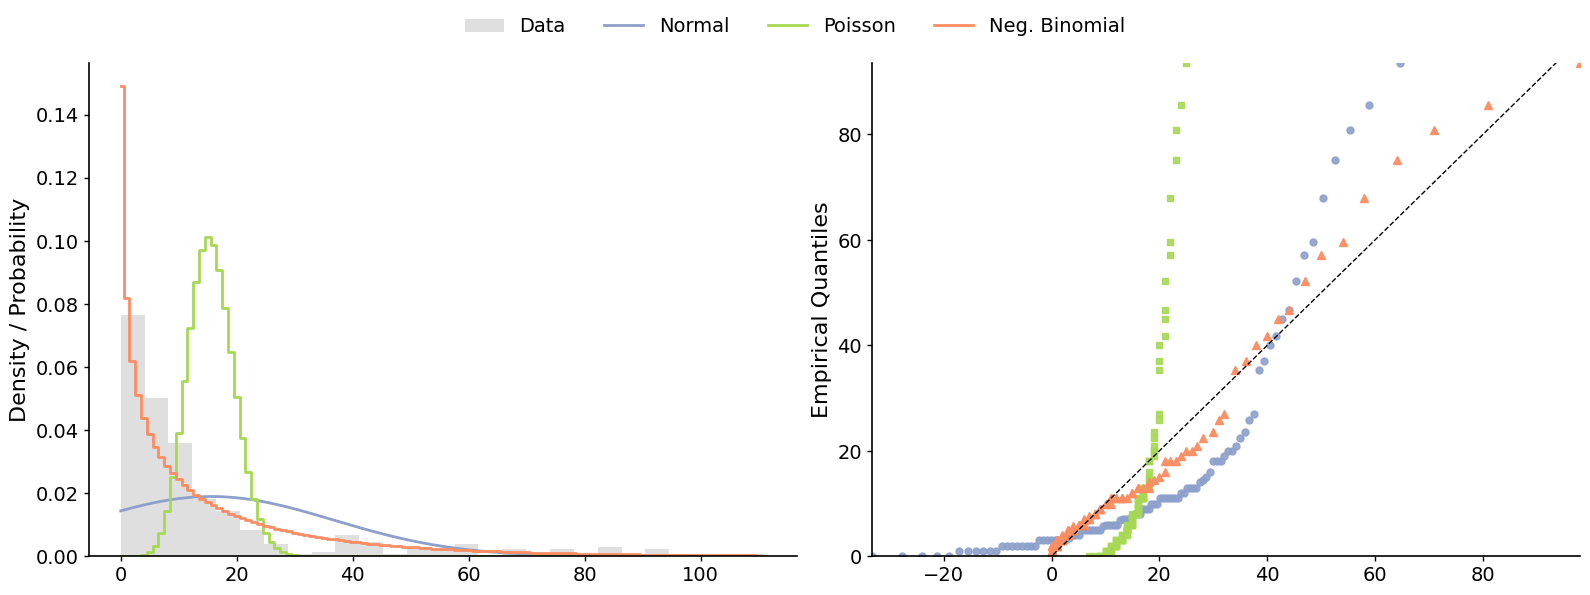

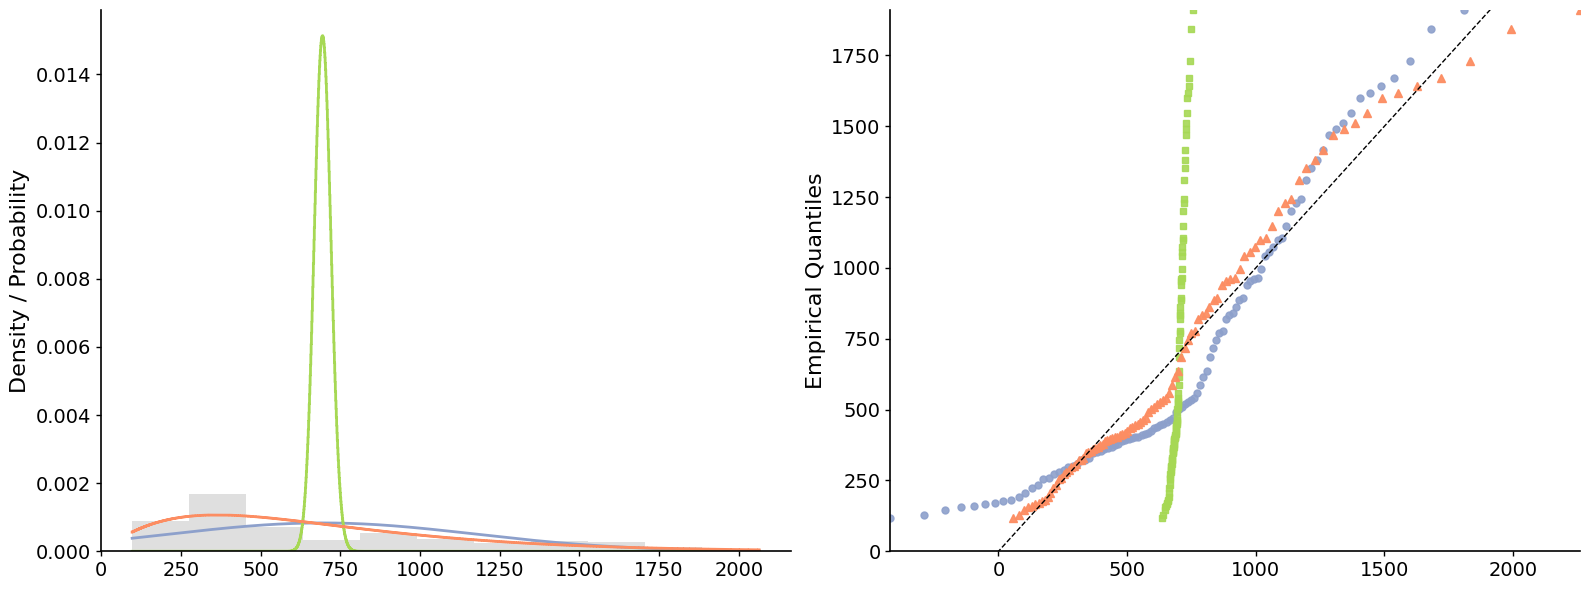

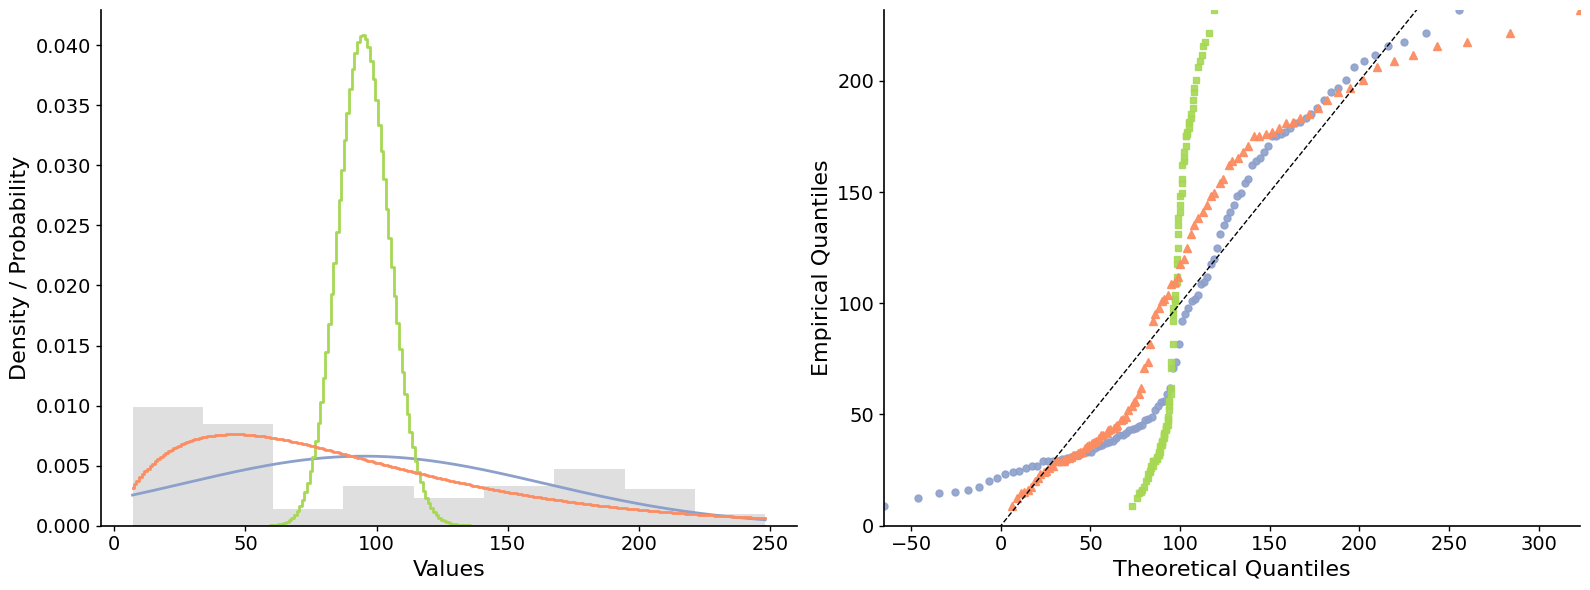

{'normal': {'mu': np.float64(95.22012578616352),
  'sigma': np.float64(68.9015931024795)},
 'poisson': {'lambda': 95.22012578616352},
 'neg_binomial': {'r': 1.9364322507618446, 'p': 0.019931050357155335}}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compare_distributions(
    data,
    show_legend: bool = True,
    show_xlabel: bool = True,
    dist_colors: dict | None = None,
    fs: int = 16,
):
    """
    Fit Normal, Poisson, and Negative Binomial to `data` and plot:
      - Left: histogram + fitted PDFs/PMFs
      - Right: multi-distribution QQ-plot
    Options:
      - show_legend: show a single shared legend on top
      - show_xlabel: include x-axis labels on both subplots
      - dist_colors: optional dict with colors for "Normal", "Poisson", "Neg. Binomial"
      - fs: base font size
    Returns:
      dict with fitted parameters.
    """

    # ---------- data -----------
    data = np.asarray(data).ravel()
    if data.size < 5:
        raise ValueError("At least 5 observations are required.")

    # ---------- fit ------------
    # Normal
    mu, sigma = stats.norm.fit(data)
    # Poisson
    lam = float(np.mean(data))
    # NegBin via method of moments (SciPy nbinom(r,p))
    m = float(np.mean(data))
    v = float(np.var(data, ddof=1))
    nbinom_params = None
    if v > m + 1e-12:
        p_hat = m / v
        r_hat = m * p_hat / (1.0 - p_hat)
        if (r_hat > 0) and (0 < p_hat < 1):
            nbinom_params = (r_hat, p_hat)

    # ---------- styling helpers ----------
    def minimal_axes(ax):
        ax.set_facecolor("white")
        ax.grid(False)
        for spine in ("top", "right"):
            ax.spines[spine].set_visible(False)
        for spine in ("left", "bottom"):
            ax.spines[spine].set_linewidth(1.2)
        ax.tick_params(axis="both", width=1.0, labelsize=fs-2)

    # Default palette (Neg. Binomial emphasized)
    if dist_colors is None:
        dist_colors = {
        "Normal": "#8da0cb",    # azul lavanda → relajado y frío
        "Poisson": "#a6d854",   # verde lima → contraste medio
        "Neg. Binomial": "#fc8d62"  # coral cálido → altamente llamativo en oscuro
        }

    # ---------- figure ----------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    minimal_axes(ax1)
    minimal_axes(ax2)

    # Left: histogram + fits
    x = np.linspace(data.min(), data.max(), 400)
    x_int = np.arange(int(np.floor(data.min())), int(np.ceil(data.max())) + 1)

    hist = ax1.hist(data, bins="auto", density=True, alpha=0.25, color="gray", label="Data")

    pdf_norm = stats.norm.pdf(x, mu, sigma)
    line_norm, = ax1.plot(x, pdf_norm, lw=2, color=dist_colors["Normal"], label="Normal")

    pmf_pois = stats.poisson.pmf(x_int, lam)
    line_pois = ax1.step(x_int, pmf_pois, where="mid", lw=2, color=dist_colors["Poisson"], label="Poisson")[0]

    line_nb = None
    if nbinom_params is not None:
        r_hat, p_hat = nbinom_params
        pmf_nb = stats.nbinom.pmf(x_int, r_hat, p_hat)
        line_nb = ax1.step(x_int, pmf_nb, where="mid", lw=2, color=dist_colors["Neg. Binomial"], label="Neg. Binomial")[0]
    else:
        print("Neg. Binomial not estimable (variance <= mean).")

    if show_xlabel:
        ax1.set_xlabel("Values", fontsize=fs)
    ax1.set_ylabel("Density / Probability", fontsize=fs)

    # Right: QQ-plot
    q = np.linspace(0.01, 0.99, 100)
    emp_q = np.quantile(data, q)

    theo_norm = stats.norm.ppf(q, mu, sigma)
    mask = np.isfinite(theo_norm) & np.isfinite(emp_q)
    ax2.plot(theo_norm[mask], emp_q[mask], "o", ms=5, color=dist_colors["Normal"], label="Normal", alpha=0.9)

    theo_pois = stats.poisson.ppf(q, lam)
    mask = np.isfinite(theo_pois) & np.isfinite(emp_q)
    ax2.plot(theo_pois[mask], emp_q[mask], "s", ms=5, color=dist_colors["Poisson"], label="Poisson", alpha=0.9)

    if nbinom_params is not None:
        theo_nb = stats.nbinom.ppf(q, r_hat, p_hat)
        mask = np.isfinite(theo_nb) & np.isfinite(emp_q)
        ax2.plot(theo_nb[mask], emp_q[mask], "^", ms=6, color=dist_colors["Neg. Binomial"], label="Neg. Binomial", alpha=0.95)

    # Diagonal and limits; enforce positive y-axis
    lo = np.nanmin([np.nanmin(emp_q), np.nanmin(theo_norm), np.nanmin(theo_pois)] + ([np.nanmin(theo_nb)] if nbinom_params is not None else []))
    hi = np.nanmax([np.nanmax(emp_q), np.nanmax(theo_norm), np.nanmax(theo_pois)] + ([np.nanmax(theo_nb)] if nbinom_params is not None else []))
    ax2.plot([lo, hi], [lo, hi], "k--", lw=1)
    ax2.set_ylim(0.0, np.nanmax(emp_q))
    ax2.set_xlim(lo, hi)

    if show_xlabel:
        ax2.set_xlabel("Theoretical Quantiles", fontsize=fs)
    ax2.set_ylabel("Empirical Quantiles", fontsize=fs)

    minimal_axes(ax1)
    minimal_axes(ax2)

    # Single shared legend (optional)
    if show_legend:
        handles = [hist[2][0], line_norm, line_pois]
        labels = ["Data", "Normal", "Poisson"]
        if line_nb is not None:
            handles.append(line_nb)
            labels.append("Neg. Binomial")
        fig.legend(handles, labels, loc="upper center", ncol=len(labels), frameon=False, prop={'size': fs-2})
        plt.tight_layout(rect=[0, 0, 1, 0.92])
    else:
        plt.tight_layout()

    plt.show()

    # Return fitted parameters
    result = {
        "normal": {"mu": mu, "sigma": sigma},
        "poisson": {"lambda": lam},
        "neg_binomial": ({"r": r_hat, "p": p_hat} if nbinom_params is not None else None),
    }
    return result


compare_distributions(segments[0],True,False)
compare_distributions(segments[1],False,False)
compare_distributions(segments[2],False,True)

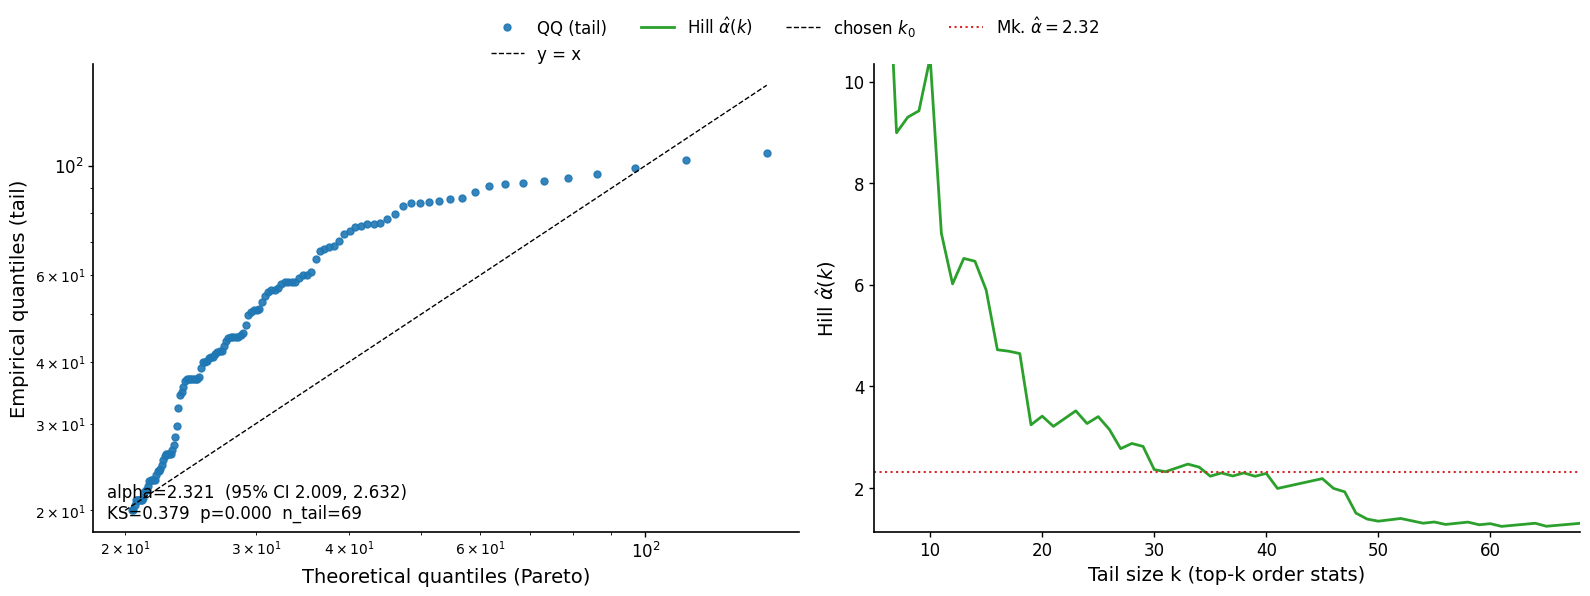

[Decision] p=0.000 ⇒ Reject power-law tail at 10% level.


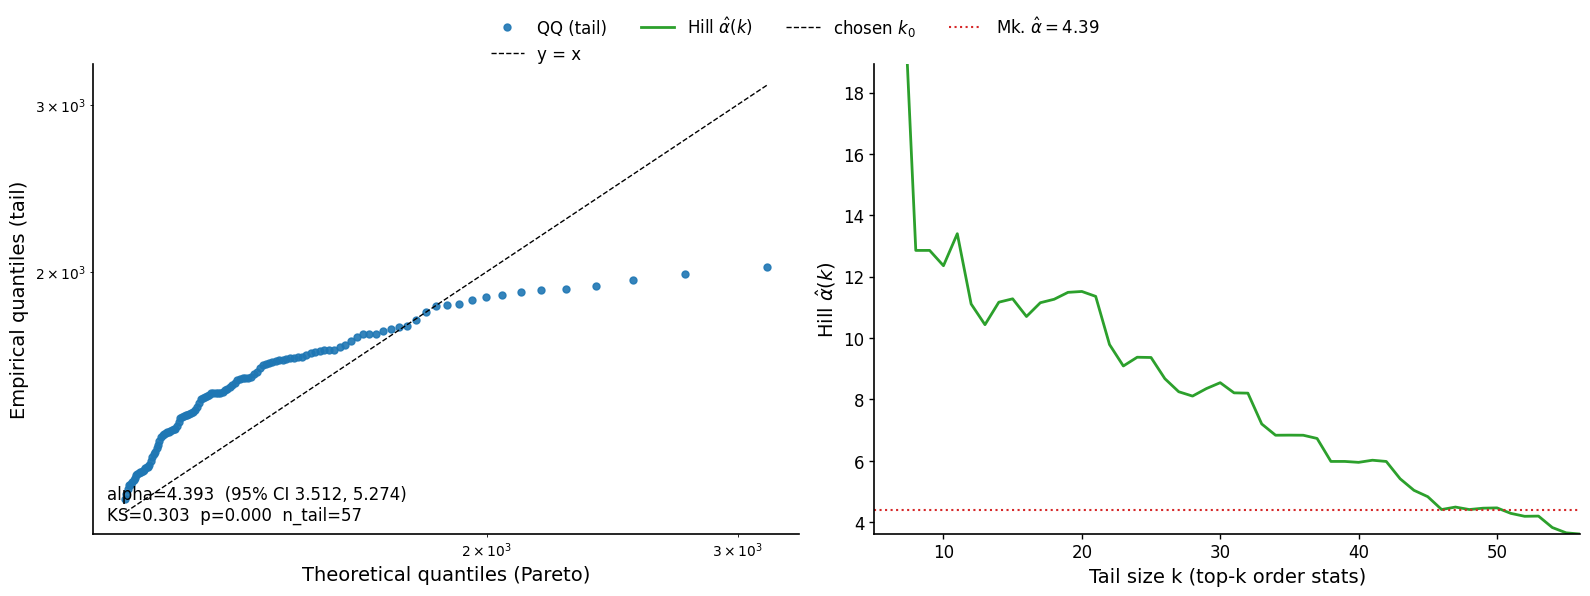

[Decision] p=0.000 ⇒ Reject power-law tail at 10% level.


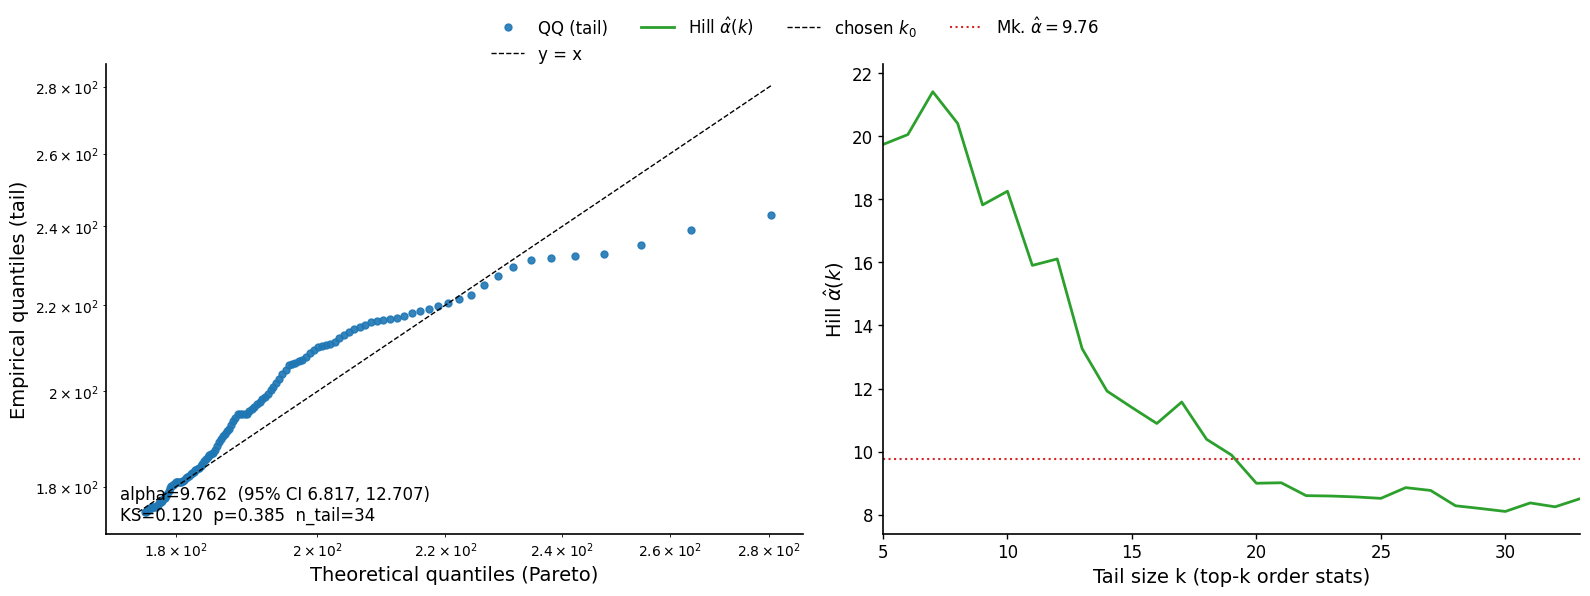

[Decision] p=0.385 ⇒ Power-law tail is plausible (not rejected).


{'xmin': 175.0,
 'n_tail': 34,
 'alpha_hat': 9.761955934942263,
 'se': 1.5026630459236061,
 'ci95': (6.8167363649319945, 12.70717550495253),
 'ks_emp': 0.12002738115103073,
 'p_value': 0.385}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def heavy_tail_test(
    data,
    xmin: float | None = None,
    n_boot: int = 200,
    fs: int = 14,
    show_legend: bool = True,
    show_xlabel: bool = True,
    random_state: int = 42,
):
    """
    Test for a heavy (power-law) upper tail using Pareto Type I beyond xmin.

    - Fits alpha by MLE on {x >= xmin}.
    - Plots:
        (left)  Log–log QQ-plot: empirical tail quantiles vs. fitted Pareto quantiles
        (right) Hill plot: alpha_hat(k) vs. tail size k; marks chosen k (x >=0.5 xmin)
    - KS bootstrap (Clauset–Shalizi–Newman): p-value for power-law plausibility
      (low p => reject heavy-tail/power-law tail).

    Parameters
    ----------
    data : array-like
        Sample (1D).
    xmin : float or None
        Threshold for tail; if None, uses the 80th percentile.
    n_boot : int
        Bootstrap replications for KS test (e.g., 200–1000).
    fs : int
        Base font size for plot labels.
    show_legend : bool
        Whether to draw a shared legend.
    show_xlabel : bool
        Whether to draw x-axis labels.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    result : dict
        {
          'xmin': float,
          'n_tail': int,
          'alpha_hat': float,
          'se': float,
          'ci95': (low, high),
          'ks_emp': float,
          'p_value': float
        }
    """
    rng = np.random.default_rng(random_state)

    # 1) Clean & prepare
    x = np.asarray(data).ravel()
    x = x[np.isfinite(x)]
    if x.size < 20:
        raise ValueError("Need at least 20 observations.")

    if xmin is None:
        xmin = float(np.percentile(x, 80))

    tail = x[x >= xmin]
    n = tail.size
    if n < 20:
        raise ValueError("Too few tail points above xmin (need >= 20).")

    # 2) MLE for Pareto Type I (Hill’s estimator for alpha)
    # alpha_hat = 1 + n / sum(log(x_i/xmin))
    s = np.sum(np.log(tail / xmin))
    alpha_hat = 1.0 + n / s
    se = (alpha_hat - 1.0) / np.sqrt(n)
    ci95 = (alpha_hat - 1.96 * se, alpha_hat + 1.96 * se)

    # 3) Empirical vs fitted CDF on tail -> KS
    def ecdf(vals):
        vals = np.sort(vals)
        def F(z):
            return np.searchsorted(vals, z, side="right") / vals.size
        return F

    F_emp = ecdf(tail)
    # Pareto CDF on [xmin, inf): F(z) = 1 - (xmin/z)^{alpha}
    def F_pareto(z, a):
        z = np.asarray(z)
        out = np.zeros_like(z, dtype=float)
        mask = z >= xmin
        out[mask] = 1.0 - (xmin / z[mask]) ** a
        out[~mask] = 0.0
        return out

    # KS distance for the observed tail
    z_grid = np.sort(tail)
    ks_emp = np.max(np.abs(F_emp(z_grid) - F_pareto(z_grid, alpha_hat)))

    # 4) Bootstrap p-value (Clauset et al. 2009)
    # Generate from fitted Pareto, re-fit alpha, compute KS each time.
    ks_boot = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        # sample from Pareto(alpha_hat, xmin): X = xmin * U^{-1/alpha}
        u = rng.random(n)
        synth = xmin * (1.0 - u) ** (-1.0 / alpha_hat)
        # re-fit alpha on synthetic sample
        s_b = np.sum(np.log(synth / xmin))
        alpha_b = 1.0 + n / s_b
        # KS on synthetic sample
        F_emp_b = ecdf(synth)
        z_b = np.sort(synth)
        ks_boot[b] = np.max(np.abs(F_emp_b(z_b) - F_pareto(z_b, alpha_b)))

    # p-value = Pr(KS_boot >= KS_emp | power-law true)
    p_value = float(np.mean(ks_boot >= ks_emp))

    # 5) Plots: (left) log–log QQ vs fitted Pareto; (right) Hill plot
    def minimal_axes(ax):
        ax.set_facecolor("white")
        ax.grid(False)
        for s in ("top", "right"):
            ax.spines[s].set_visible(False)
        for s in ("left", "bottom"):
            ax.spines[s].set_linewidth(1.2)
        ax.tick_params(axis="both", width=1.0, labelsize=fs-2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    minimal_axes(ax1); minimal_axes(ax2)

    # (left) Log–log QQ: empirical quantiles vs theoretical (Pareto fitted)
    q = np.linspace(0.05, 0.99, 120)
    emp_q = np.quantile(tail, q)
    # Theoretical Pareto quantiles: Q(p) = xmin * (1 - p)^(-1/alpha_hat)
    theo_q = xmin * (1.0 - q) ** (-1.0 / alpha_hat)

    ax1.plot(theo_q, emp_q, "o", ms=5, alpha=0.9, color="#1f77b4", label="QQ (tail)")
    # reference line y=x
    lo = min(emp_q.min(), theo_q.min())
    hi = max(emp_q.max(), theo_q.max())
    ax1.plot([lo, hi], [lo, hi], "k--", lw=1, label="y = x")

    ax1.set_xscale("log"); ax1.set_yscale("log")
    if show_xlabel: ax1.set_xlabel("Theoretical quantiles (Pareto)", fontsize=fs)
    ax1.set_ylabel("Empirical quantiles (tail)", fontsize=fs)

    # Add small caption with alpha, KS, p
    ax1.text(0.02, 0.02,
             f"alpha={alpha_hat:.3f}  (95% CI {ci95[0]:.3f}, {ci95[1]:.3f})\n"
             f"KS={ks_emp:.3f}  p={p_value:.3f}  n_tail={n}",
             transform=ax1.transAxes, ha="left", va="bottom", fontsize=fs-2)

    # (right) Hill plot: alpha_hat(k) for top-k order statistics
    # Sort descending; for each k, u = tail[k-1] (kth largest threshold)
    xs = np.sort(tail)[::-1]
    k_vals = np.arange(5, n)  # start at 5 to avoid high variance at tiny k
    hill_alpha = []
    for k in k_vals:
        u = xs[k-1]  # threshold = kth largest value
        s_k = np.sum(np.log(xs[:k] / u))
        # Hill tail index gamma_hat = (1/k) * sum log(X_i/u); alpha_hat = 1/gamma_hat
        gamma_hat = s_k / k
        if gamma_hat > 0:
            hill_alpha.append(1.0 / gamma_hat)
        else:
            hill_alpha.append(np.nan)
    hill_alpha = np.asarray(hill_alpha)

    ax2.plot(k_vals, hill_alpha, "-", lw=2, color="#2ca02c", label=r"Hill $\hat{\alpha}(k)$")
    # Mark chosen k0 corresponding to xmin (all points >= xmin)
    k0 = int(np.sum(tail >= xmin))
    ax2.axvline(k0, color="k", lw=1, ls="--", label=r"chosen $k_0$")
    ax2.axhline(alpha_hat, color="#d62728", lw=1.5, ls=":", label=rf"Mk. $\hat\alpha={alpha_hat:.2f}$")

    ax2.set_xlim(k_vals.min(), k_vals.max())
    # y-limits padded
    ylo = np.nanpercentile(hill_alpha, 5)
    yhi = np.nanpercentile(hill_alpha, 95)
    ax2.set_ylim(max(0.0, ylo*0.9), yhi*1.1)

    if show_xlabel: ax2.set_xlabel("Tail size k (top-k order stats)", fontsize=fs)
    ax2.set_ylabel(r"Hill $\hat{\alpha}(k)$", fontsize=fs)

    if show_legend:
        fig.legend(loc="upper center", ncol=4, frameon=False, prop={'size': fs-2})
        plt.tight_layout(rect=[0, 0, 1, 0.92])
    else:
        plt.tight_layout()

    plt.show()

    # 6) Decision note (rule of thumb)
    # Common interpretation: if p-value < 0.1 (or 0.05), power-law tail is unlikely/plausibly rejected.
    result = {
        "xmin": float(xmin),
        "n_tail": int(n),
        "alpha_hat": float(alpha_hat),
        "se": float(se),
        "ci95": (float(ci95[0]), float(ci95[1])),
        "ks_emp": float(ks_emp),
        "p_value": float(p_value),
    }
    if p_value < 0.1:
        print(f"[Decision] p={p_value:.3f} ⇒ Reject power-law tail at 10% level.")
    else:
        print(f"[Decision] p={p_value:.3f} ⇒ Power-law tail is plausible (not rejected).")

    return result

heavy_tail_test(segments[0])
heavy_tail_test(segments[1])
heavy_tail_test(segments[2])

# **Model Comparison: Gaussian, Poisson, and Negative Binomial**

This notebook explains how to **compare three statistical models** — **Gaussian (Normal)**, **Poisson**, and **Negative Binomial** — using **Maximum Likelihood Estimation (MLE)**, **AIC/BIC** model selection, and a **Chi-square Goodness-of-Fit (GOF)** test.

---

## **1) Maximum Likelihood Estimation (MLE)**

For each model $M$ with parameters $\theta$, we estimate $\hat{\theta}$ by maximizing the **log-likelihood**:

$$
\hat{\theta} = \arg\max_{\theta} \ \ell_M(\theta),
$$

where:

$$
\ell_M(\theta) = \sum_{i=1}^n \ln f_M(x_i \mid \theta).
$$

### **1.1 Gaussian (Normal)**

- **PDF**:
  $$
  f(x \mid \mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}
  \exp\!\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
  $$
- **Parameters estimated**:
  $$
  \hat{\mu} = \frac{1}{n}\sum_{i=1}^n x_i,
  \qquad
  \hat{\sigma}^2 = \frac{1}{n}\sum_{i=1}^n(x_i - \hat{\mu})^2.
  $$

---

### **1.2 Poisson**

- **PMF**:
  $$
  f(x\mid\lambda)=\frac{e^{-\lambda}\lambda^x}{x!},
  \qquad x \in \{0,1,2,\dots\}
  $$
- **Parameter estimated**:
  $$
  \hat{\lambda} = \bar{x}.
  $$

---

### **1.3 Negative Binomial**

For **count data with overdispersion** $(\mathrm{Var}(X) > \mathbb{E}[X])$:

- **PMF** (SciPy’s parameterization):
  $$
  f(x\mid r,p)=
  \binom{x+r-1}{x}(1-p)^x p^r,
  $$
  where:
  - $r$ = shape (“number of successes”),
  - $p$ = success probability.
- **Method of Moments**:
  $$
  \hat{r} = \frac{\bar{x}^2}{s^2 - \bar{x}}, \qquad
  \hat{p} = \frac{\hat{r}}{\hat{r} + \bar{x}},
  $$
  where $\bar{x}$ = sample mean and $s^2$ = sample variance.

> **Note:** If $s^2 \le \bar{x}$, the Negative Binomial is **not identifiable** because variance is not larger than the mean.

---

## **2) Model Selection Criteria**

We compare models using two **information criteria**:

### **2.1 Akaike Information Criterion (AIC)**

$$
\boxed{
\mathrm{AIC} = 2k - 2\ell_{\max}
}
$$

- $k$ = number of free parameters.
- Lower AIC $\Rightarrow$ better trade-off between fit and complexity.

---

### **2.2 Bayesian Information Criterion (BIC)**

$$
\boxed{
\mathrm{BIC} = k\ln(n) - 2\ell_{\max}
}
$$

- $k$ = number of free parameters.
- $n$ = sample size.
- Lower BIC $\Rightarrow$ better fit penalizing model complexity **more strongly** than AIC.

---

## **3) Goodness-of-Fit Test (Chi-square)**

To evaluate how well each model explains the observed data:

1. Divide the data into $m$ bins: $[b_{j-1}, b_j)$.
2. **Observed counts**:  
   $$
   O_j = \#\{x_i \in [b_{j-1}, b_j)\}
   $$
3. **Expected counts under the fitted model**:  
   $$
   E_j = n \cdot \big[F(b_j) - F(b_{j-1})\big],
   $$
   where $F$ is the fitted **CDF**.
4. **Chi-square statistic**:
   $$
   \chi^2 = \sum_{j=1}^m \frac{(O_j - E_j)^2}{E_j}.
   $$
5. **Degrees of freedom**:
   $$
   \nu = m - k - 1.
   $$
6. **p-value**:
   $$
   p = 1 - F_{\chi^2}(\chi^2; \nu).
   $$

- If $p \ge 0.05$: the model **is not rejected** → **adequate fit**.
- If $p < 0.05$: the model **is rejected** → **poor fit**.

---

## **4) Table Components**

The final comparison table has these columns:

| **Column**      | **Meaning**                                                                 |
|------------------|----------------------------------------------------------------------------|
| **loglik**       | Maximized log-likelihood $\ell(\hat\theta)$                                 |
| **AIC**          | Penalized fit measure: lower AIC = better fit                               |
| **BIC**          | Stricter penalized fit measure: lower BIC = better fit                      |
| **gof\_stat**    | Chi-square statistic $\chi^2$: measures discrepancy between observed and expected counts |
| **gof\_pvalue**  | p-value from GOF test: higher = better fit                                  |

---

## **5) Model Selection Logic**

1. **Check GOF adequacy**:  
   - Models with $p \ge 0.05$ are considered **adequate**.
2. Among adequate models, choose the one with **lowest BIC** (tie-breaker: AIC).
3. If **no model** has $p \ge 0.05$, choose the **lowest BIC overall**, but note that **none fit adequately**.

---

## **6) Interpretation**

- **Highest log-likelihood** $\rightarrow$ best raw fit.
- **Lowest AIC/BIC** $\rightarrow$ best balance of fit vs. complexity.
- **Highest GOF p-value** $\rightarrow$ model most consistent with observed data.
- If **Poisson** fails and **Negative Binomial** succeeds, it indicates **overdispersion** (variance $\gg$ mean).
- If all models fail, consider **alternative distributions** (e.g., zero-inflated models, mixtures, lognormal, etc.).

---

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

def _chisq_gof_from_cdf(data, cdf_fn, n_params, bins="auto"):
    """
    Generic chi-square GOF helper given a CDF function cdf_fn(x).
    - data: 1D array
    - cdf_fn: function that returns CDF at array of bin edges
    - n_params: number of estimated parameters (k)
    - bins: "auto" or explicit bin edges (for discrete models use integer bins)
    Returns (stat, pvalue).
    """
    n = data.size
    obs, edges = np.histogram(data, bins=bins)
    # Expected counts under fitted model
    cdf_edges = cdf_fn(edges)
    exp = n * np.diff(cdf_edges)
    # Avoid zero division; merge tiny expected bins if any
    mask = exp > 1e-8
    obs, exp = obs[mask], exp[mask]
    # Chi-square stat
    chi2 = np.sum((obs - exp) ** 2 / (exp + 1e-12))
    dof = max(len(obs) - n_params - 1, 1)
    pval = 1.0 - stats.chi2.cdf(chi2, dof)
    return float(chi2), float(pval)

def compare_distributions(data, return_winner=True):
    """
    Compare Gaussian, Poisson, and Negative Binomial on `data`.
    Returns a pandas DataFrame with: loglik, AIC, BIC, gof_stat, gof_pvalue,
    plus (optionally) a dict describing the winner and the selection rationale.

    Selection rule:
      1) Prefer models with GOF p >= 0.05; among those, choose lowest BIC (then AIC).
      2) If none pass p >= 0.05, choose lowest BIC overall and warn about GOF.
    """
    x = np.asarray(data).ravel()
    x = x[np.isfinite(x)]
    n = x.size
    if n < 5:
        raise ValueError("At least 5 observations are required.")

    results = {}
    details = {}

    # ---------- Normal ----------
    mu, sigma = stats.norm.fit(x)
    loglik_norm = np.sum(stats.norm.logpdf(x, mu, sigma))
    k_norm = 2
    aic_norm = 2*k_norm - 2*loglik_norm
    bic_norm = k_norm*np.log(n) - 2*loglik_norm

    # GOF via chi-square using automatic bins
    gof_stat_norm, gof_p_norm = _chisq_gof_from_cdf(
        x, lambda z: stats.norm.cdf(z, mu, sigma), n_params=k_norm, bins="auto"
    )

    results["Normal"] = [loglik_norm, aic_norm, bic_norm, gof_stat_norm, gof_p_norm]
    details["Normal"] = {"mu": mu, "sigma": sigma}

    # ---------- Poisson ----------
    lam = float(np.mean(x))
    # For Poisson, data should be counts; if not integers, still compute logpmf on rounded?
    # Here we assume counts; if not, cast if very close to ints:
    if not np.all(np.isclose(x, np.round(x))):
        # If you want strictly discrete, uncomment next line:
        # x_disc = np.round(x).astype(int)
        x_disc = x  # leave as-is; SciPy will return -inf for invalid support
    else:
        x_disc = x.astype(int)

    loglik_pois = np.sum(stats.poisson.logpmf(x_disc, lam))
    k_pois = 1
    aic_pois = 2*k_pois - 2*loglik_pois
    bic_pois = k_pois*np.log(n) - 2*loglik_pois

    # Use integer bins for counts
    min_bin = int(np.floor(np.min(x_disc)))
    max_bin = int(np.ceil(np.max(x_disc)))
    edges_disc = np.arange(min_bin, max_bin + 2)  # inclusive of last count
    gof_stat_pois, gof_p_pois = _chisq_gof_from_cdf(
        x_disc, lambda z: stats.poisson.cdf(z, lam), n_params=k_pois, bins=edges_disc
    )

    results["Poisson"] = [loglik_pois, aic_pois, bic_pois, gof_stat_pois, gof_p_pois]
    details["Poisson"] = {"lambda": lam}

    # ---------- Negative Binomial ----------
    # Method-of-moments (works across SciPy versions where .fit may not exist)
    m = float(np.mean(x_disc))
    v = float(np.var(x_disc, ddof=1))
    if v > m + 1e-12:
        r_hat = m**2 / (v - m)           # "size" or r (shape)
        p_hat = r_hat / (r_hat + m)      # success prob in SciPy's nbinom(r, p)
        print('Dispersion '+str(r_hat))
        loglik_nb = np.sum(stats.nbinom.logpmf(x_disc, r_hat, p_hat))
        k_nb = 2
        aic_nb = 2*k_nb - 2*loglik_nb
        bic_nb = k_nb*np.log(n) - 2*loglik_nb

        gof_stat_nb, gof_p_nb = _chisq_gof_from_cdf(
            x_disc, lambda z: stats.nbinom.cdf(z, r_hat, p_hat), n_params=k_nb, bins=edges_disc
        )
        results["Neg. Binomial"] = [loglik_nb, aic_nb, bic_nb, gof_stat_nb, gof_p_nb]
        details["Neg. Binomial"] = {"r": r_hat, "p": p_hat}
    else:
        # Not overdispersed relative to Poisson; NB not applicable
        results["Neg. Binomial"] = [np.nan, np.nan, np.nan, np.nan, np.nan]
        details["Neg. Binomial"] = {"r": np.nan, "p": np.nan, "note": "variance <= mean; NB not identifiable"}

    # ---------- Build table ----------
    dfResults = pd.DataFrame(results, index=["loglik", "AIC", "BIC", "gof_stat", "gof_pvalue"]).T

    # ---------- Choose winner ----------
    if return_winner:
        # Candidates with adequate GOF
        adequate = dfResults[dfResults["gof_pvalue"] >= 0.05]
        used_df = adequate if not adequate.empty else dfResults

        # Rank by BIC then AIC
        winner = used_df.sort_values(["BIC", "AIC"], ascending=True).iloc[0]
        winner_name = used_df.sort_values(["BIC", "AIC"], ascending=True).index[0]

        rationale = []
        if adequate.empty:
            rationale.append("No model passed GOF (p >= 0.05); selected the lowest BIC overall.")
        else:
            rationale.append("Among models with GOF p >= 0.05, selected the lowest BIC (tie-breaker: AIC).")

        rationale.append(f"Winner = {winner_name} "
                         f"(BIC={winner['BIC']:.2f}, AIC={winner['AIC']:.2f}, "
                         f"loglik={winner['loglik']:.2f}, GOF p={winner['gof_pvalue']:.3g})")

        return dfResults, {"winner": winner_name, "metrics": winner.to_dict(), "rationale": " ".join(rationale), "params": details[winner_name]}

    return dfResults

ks = 1
for segData in segments:
    print(f"\n\nSegment: "+str(ks))
    dfResults, summary = compare_distributions(segData)
    print(dfResults)
    print(summary)
    ks = ks + 1

    from IPython.display import display, HTML

    # Assuming df is your DataFrame
    display(HTML(dfResults.to_html()))



Segment: 1
Dispersion 0.5687226455099424
                    loglik          AIC          BIC      gof_stat  \
Normal        -1446.994025  2897.988049  2905.549536  1.983359e+03   
Poisson       -3906.704882  7815.409764  7819.190507  1.606874e+08   
Neg. Binomial -1227.785545  2459.571090  2467.132577  2.398577e+02   

                 gof_pvalue  
Normal         0.000000e+00  
Poisson        0.000000e+00  
Neg. Binomial  7.824297e-12  
{'winner': 'Neg. Binomial', 'metrics': {'loglik': -1227.7855450611107, 'AIC': 2459.5710901222214, 'BIC': 2467.1325771538063, 'gof_stat': 239.85773612248195, 'gof_pvalue': 7.82429676604579e-12}, 'rationale': 'No model passed GOF (p >= 0.05); selected the lowest BIC overall. Winner = Neg. Binomial (BIC=2467.13, AIC=2459.57, loglik=-1227.79, GOF p=7.82e-12)', 'params': {'r': 0.5687226455099424, 'p': 0.03512998813164315}}


,loglik,AIC,BIC,gof_stat,gof_pvalue
Normal,-1446.994025,2897.988049,2905.549536,1.983359e+03,0.000000e+00
Poisson,-3906.704882,7815.409764,7819.190507,1.606874e+08,0.000000e+00
Neg. Binomial,-1227.785545,2459.571090,2467.132577,2.398577e+02,7.824297e-12




Segment: 2
Dispersion 2.0991909122090746
                     loglik           AIC           BIC      gof_stat  \
Normal         -2163.575244   4331.150488   4338.455467  1.493271e+02   
Poisson       -45484.613110  90971.226219  90974.878709  2.462403e+08   
Neg. Binomial  -2109.499265   4222.998530   4230.303509  2.344824e+03   

                 gof_pvalue  
Normal         0.000000e+00  
Poisson        0.000000e+00  
Neg. Binomial  5.397483e-09  
{'winner': 'Neg. Binomial', 'metrics': {'loglik': -2109.499265205473, 'AIC': 4222.998530410946, 'BIC': 4230.303508771483, 'gof_stat': 2344.8238431322106, 'gof_pvalue': 5.397482572000456e-09}, 'rationale': 'No model passed GOF (p >= 0.05); selected the lowest BIC overall. Winner = Neg. Binomial (BIC=4230.30, AIC=4223.00, loglik=-2109.50, GOF p=5.4e-09)', 'params': {'r': 2.0991909122090746, 'p': 0.0030123238276067075}}


,loglik,AIC,BIC,gof_stat,gof_pvalue
Normal,-2163.575244,4331.150488,4338.455467,1.493271e+02,0.000000e+00
Poisson,-45484.613110,90971.226219,90974.878709,2.462403e+08,0.000000e+00
Neg. Binomial,-2109.499265,4222.998530,4230.303509,2.344824e+03,5.397483e-09




Segment: 3
Dispersion 1.9364322507618443
                    loglik          AIC          BIC      gof_stat  gof_pvalue
Normal         -898.607235  1801.214471  1807.352279  1.106034e+02    0.000000
Poisson       -4551.004001  9104.008002  9107.076906  5.015566e+08    0.000000
Neg. Binomial  -873.927192  1751.854385  1757.992193  3.218769e+02    0.000276
{'winner': 'Neg. Binomial', 'metrics': {'loglik': -873.9271924916821, 'AIC': 1751.8543849833643, 'BIC': 1757.9921933878047, 'gof_stat': 321.87693848685774, 'gof_pvalue': 0.0002762523892521074}, 'rationale': 'No model passed GOF (p >= 0.05); selected the lowest BIC overall. Winner = Neg. Binomial (BIC=1757.99, AIC=1751.85, loglik=-873.93, GOF p=0.000276)', 'params': {'r': 1.9364322507618443, 'p': 0.019931050357155335}}


,loglik,AIC,BIC,gof_stat,gof_pvalue
Normal,-898.607235,1801.214471,1807.352279,1.106034e+02,0.000000
Poisson,-4551.004001,9104.008002,9107.076906,5.015566e+08,0.000000
Neg. Binomial,-873.927192,1751.854385,1757.992193,3.218769e+02,0.000276


In [ ]:
print(dfResults)

                    loglik          AIC          BIC      gof_stat  gof_pvalue
Normal         -898.607235  1801.214471  1807.352279  1.106034e+02    0.000000
Poisson       -4551.004001  9104.008002  9107.076906  5.015566e+08    0.000000
Neg. Binomial  -873.927192  1751.854385  1757.992193  3.218769e+02    0.000276


# Modeling the cost function using Negative Binomial

Let's assume that within each region: (i) victimization events occur independently, so the occurrence of one event does not influence the probability of another; (ii) the underlying rate of victimization $\lambda_i$ is constant over the observation period (in this case, a month); and (iii) the probability of two or more events occurring simultaneously is negligible. Under these assumptions, the number of victims in region $i$ can be naturally modeled by a Poisson random variable. The Poisson model provides a natural starting point for modeling the number of victims per region because it offers a simple and interpretable framework for count data and assumes that all variability arises from random fluctuations around a constant rate.

A key property of the Poisson model is that the variance equals the mean, $\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i$, capturing the idea that there are no additional sources of heterogeneity influencing victim counts beyond random variation. However, in many real-world scenarios involving victims of internal armed conflict (IAC), this assumption is often violated. The data tend to vary more than the Poisson model predicts, a phenomenon known as overdispersion, which occurs when $\mathrm{Var}(Y_i) > \mathbb{E}[Y_i]$. Overdispersion commonly arises from unobserved heterogeneity across regions, where some areas have persistently higher or lower victimization rates than average, or due to unmeasured risk factors that influence victimization dynamics.

In the specific context of the Colombian internal armed conflict, overdispersion in the number of victims per region is expected due to the strong heterogeneity in violence dynamics across space and time. Some regions experience intense and concentrated episodes of violence driven by the presence of armed groups, strategic territorial disputes, or economic interests, while others remain relatively unaffected. Moreover, victimization patterns often occur in bursts or clusters rather than being evenly distributed, as conflict-related events are frequently triggered by localized escalations, retaliatory attacks, or resource-driven confrontations. Additional unobserved factors, such as differences in state presence, local governance, geography, and socioeconomic conditions, further amplify variability between regions. These combined effects lead to situations where the variance of victim counts is substantially larger than the mean, making overdispersion an inherent characteristic of the victimization data.

To account for this additional variability, we relax the assumption of a fixed victimization rate $\lambda_i$ and instead model it as a random variable following a Gamma distribution. The Gamma distribution is a natural choice for modeling variability in victimization rates across regions because it is defined on positive values, matches the nature of rate parameters, and flexibly captures unobserved heterogeneity. This hierarchical specification leads to a Poisson–Gamma mixture, where the marginal distribution of victim counts follows a Negative Binomial (NB) distribution, which naturally accommodates the observed overdispersion while keeping the Poisson model as a special case when heterogeneity is absent.

The Negative Binomial (NB) distribution is commonly defined using two parameters $(r, p)$, it assigns probabilities to $Y \in \{0, 1, 2, \dots\}$, a random variable representing the number of failures before achieving $r$ successes in i.i.d. Bernoulli trials with success probability $p$. The probability mass function (pmf) is given by:

$$
P(Y = y) = \frac{\Gamma(y+r)}{\Gamma(r)\, y!} (1-p)^y \, p^r,
\quad y \in \{0,1,2,\dots\}.
$$

In this parameterization:

$$
\mathbb{E}[Y] = r \cdot \frac{1-p}{p},
\qquad
\mathrm{Var}(Y) = r \cdot \frac{1-p}{p^2}.
$$

This formulation can be reparameterized in terms of the mean $\mu = \mathbb{E}[Y]$ and the parameter $r$, using the relationships:

$$
p = \frac{r}{r + \mu},
\qquad
1-p = \frac{\mu}{r + \mu},
$$

and substituting back into the pmf yields:

$$
\tag{1}
P(Y = y) =
\frac{\Gamma(y+r)}{\Gamma(r)\,y!}
\left(\frac{r}{r+\mu}\right)^r
\left(\frac{\mu}{r+\mu}\right)^y,
\quad y \in \{0,1,2,\dots\}.
$$

In this parameterization, the variance can be rewritten as:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{r}.
$$

In this form it is clear the parameter $r$ controls the dispersion, i.e., larger $r$ implies variance closer to the mean (approaching the Poisson case), while smaller $r$ produces higher **overdispersion**.


## Model of countings of violence for the segmentation problem

For the segmentation problem $r$ is globally fixed, and $\mu$ can is estimated separately for each segment. This assumption reflects the hypothesis that the *underlying heterogeneity* in the counts remained stable across periods, even if the mean levels changed. Therefore, we adopt a common $r$ for reasons of parsimony and interpretability.


Following the previous finding, a segment of time series between $[s, e)$ and length $n = e - s$ will be model using the reparametrized NB2 pmf model (1), i.e., the counts of violence $y_s, \dots, y_{e-1}$ in the segment will be i.i.d. under (1).

### Log-likelihood within a segment

The the log-likehood of (1) is:

$$
\ell(\mu; r) =
\sum_{t=s}^{e-1} \left[
  \log \Gamma(y_t + r) - \log \Gamma(r) - \log(y_t!)
  + r \log \frac{r}{r + \mu}
  + y_t \log \frac{\mu}{r + \mu}
\right].
$$

Grouping terms that depend on $\mu$ the log-likehood can be written as:

$$
\ell(\mu; r) = C(y, r)
+ n\,r \log r
+ S \log \mu
- (n\,r + S)\,\log(r + \mu).
$$

with $C(y, r)$ a term which does not depent on $\mu$, $S = \sum_{t=s}^{e-1} y_t$ the sum of the violence indicators in the segment and
and $\bar{y} = S/n$ mean of the indicator of violence. Using this last expression the maximum likehood estimator (MLE) of $\mu$ with a fixed $r$ is obtained by
differentiating with respect to $\mu$ and setting to zero:

$$
\frac{\partial \ell}{\partial \mu} =
\frac{S}{\mu} - \frac{n\,r + S}{r + \mu} = 0
\quad\Rightarrow\quad \widehat{\mu} = \bar{y} = \frac{S}{n}.
$$

Then the cost function for the segment will correspond to negative log-likelihood, which can be obtained by substituting $\widehat{\mu} = \bar{y}$ and ignoring global constants, as follows:

$$
\mathcal{C}(s,e)
= (n\,r + S)\,\log(r + \bar{y})
- S\,\log \bar{y}
- n\,r\,\log r
$$

### Interpretation

- **Model**: NB2 captures overdispersion in count data ($\mathrm{Var} > \mathrm{E}$).
- **Parameters**: $r$ is fixed globally; $\mu$ is estimated per segment ($\bar{y}$).
- **Cost**: depends only on $n$ and $S$; computable in $O(1)$ with cumulative sums.
- **Advantage**: avoids overfitting and enables segmentation of rare/clustered events  
  (e.g., violent incidents) where variance exceeds the mean.



## Estimating the dispersion parameter $r$ (NB2) with the method of moments

For the NB2 parametrization:

$$
\mathbb{E}[Y] = \mu, \quad
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{r},
$$

we can solve for $r$ in terms of the sample mean $\hat{\mu}$ and sample variance $\hat{\sigma}^2$:

1. Start from the variance formula:
$$
\hat{\sigma}^2 \approx \mu + \frac{\mu^2}{r}.
$$

2. Rearrange to isolate $\frac{1}{r}$:
$$
\hat{\sigma}^2 - \mu \approx \frac{\mu^2}{r}.
$$

3. Solve for $r$:
$$
\hat{r} \approx \frac{\mu^2}{\hat{\sigma}^2 - \mu}.
$$

---

### Practical considerations:
- If $\hat{\sigma}^2 > \mu$, there is **overdispersion**, and the formula above gives a positive $\hat{r}$.
- If $\hat{\sigma}^2 \le \mu$, there is **no overdispersion** (variance not greater than the mean).  
  In that case, we can set $\hat{r}$ to a large value (e.g. $10^6$) to approximate the Poisson case.
- $\hat{\mu}$ and $\hat{\sigma}^2$ are computed over the **entire** series when estimating a **global** $r$.

In [ ]:
import math
import numpy as np
import ruptures as rpt
from ruptures.base import BaseCost

class CostNegBinomial(BaseCost):
    """
    Negative Binomial (NB2) segment cost with a fixed global 'r' (dispersion).
    Cost for segment [start, end):
        C = (n*r + S) * log(1 + S/(n*r)) + S * log((n*r)/S)
    where n = end - start, S = sum(y[start:end]).
    Convention: if S == 0, C = 0 (correct limit).
    """
    model = "neg_binom"

    def __init__(self, r=5.0, min_size=2, jump=1):
        if r <= 0:
            raise ValueError("Dispersion parameter r must be positive.")
        self.r = float(r)
        self.min_size = int(min_size)
        self.jump = int(jump)
        self._cum_sum = None
        self._n_samples = None
        self.signal = None  # <-- make sure ruptures can read the signal

    def fit(self, signal):
        """
        signal: array-like of shape (T,) or (T,1); non-negative counts.
        """
        y = np.asarray(signal)
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        if y.shape[1] != 1:
            raise ValueError("CostNegBinomial supports univariate series only (counts).")
        if np.any(y < 0):
            raise ValueError("Found negative values; expected non-negative counts.")

        self.signal = y               # <-- expose signal for ruptures
        self._n_samples = y.shape[0]
        y1 = y[:, 0].astype(float)
        self._cum_sum = np.concatenate(([0.0], np.cumsum(y1)))
        return self

    def error(self, start, end):
        """
        Segment cost for [start, end).
        """
        n = end - start
        if n < self.min_size:
            return np.inf

        S = self._cum_sum[end] - self._cum_sum[start]
        if S <= 0.0:
            # All-zero segment (or numerically zero): limit cost is 0
            return 0.0

        r = self.r
        # Stable form: log(1 + S/(n*r)) and log((n*r)/S)
        return (n * r + S) * math.log1p(S / (n * r)) + S * (math.log(n * r) - math.log(S))

    def sum_of_costs(self, bkps):
        """
        Optional helper: sum costs over a list of breakpoints (must include T).
        """
        start = 0
        total = 0.0
        for end in bkps:
            total += self.error(start, end)
            start = end
        return total

def estimate_r_nb2_global(y):
    """
    Estimate the global dispersion parameter 'r' using the NB2 method of moments.
    If there is no overdispersion, return a large r (≈ Poisson).
    """
    y = np.asarray(y).astype(float).reshape(-1)
    mu = y.mean()
    var = y.var(ddof=1) if y.size > 1 else 0.0
    # If there is overdispersion
    if var > mu and mu > 0:
        r_hat = (mu * mu) / (var - mu)
        # Avoid extreme values
        return float(max(r_hat, 1e-6))
    else:
        # No apparent overdispersion
        return 1e6  # approximates Poisson

T=768, min=0.000, max=2064.000, mean=284.128
Estimated global r (NB2, moments): 0.4322
Single-run bkps (pen=log(T)): [95, 225, 275, 335, 455, 580, 685, 768] | #changes: 7

CROPS-like sweep collected 6 unique optimal segmentations.
pen=3.322 -> k=10, bkps(head)=[105, 120, 230, 275] ...
pen=3.748 -> k=8, bkps(head)=[105, 120, 235, 300] ...
pen=6.729 -> k=7, bkps(head)=[95, 225, 275, 335] ...
pen=7.581 -> k=5, bkps(head)=[275, 335, 455, 580] ...
pen=11.840 -> k=4, bkps(head)=[275, 360, 595, 690] ...
pen=18.654 -> k=3, bkps(head)=[275, 360, 610, 768] ...


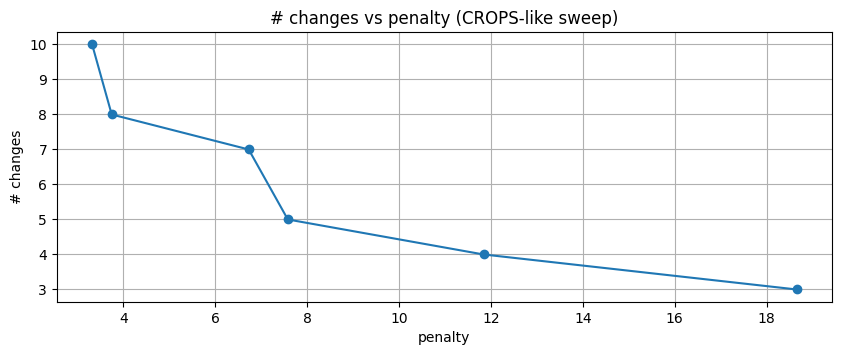


Chosen (strategy=stable): pen=6.729 -> k=7, bkps=[95, 225, 275, 335, 455, 580, 685, 768]

Cost summary:
Baseline: k=7, pen=6.644, unpen=2018.856, penalized=2065.362
Chosen:   k=7, pen=6.729, unpen=2018.856, penalized=2065.959


/tmp/ipython-input-258792098.py:292: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df[date_col].to_numpy())  # ensure 1D datetime array


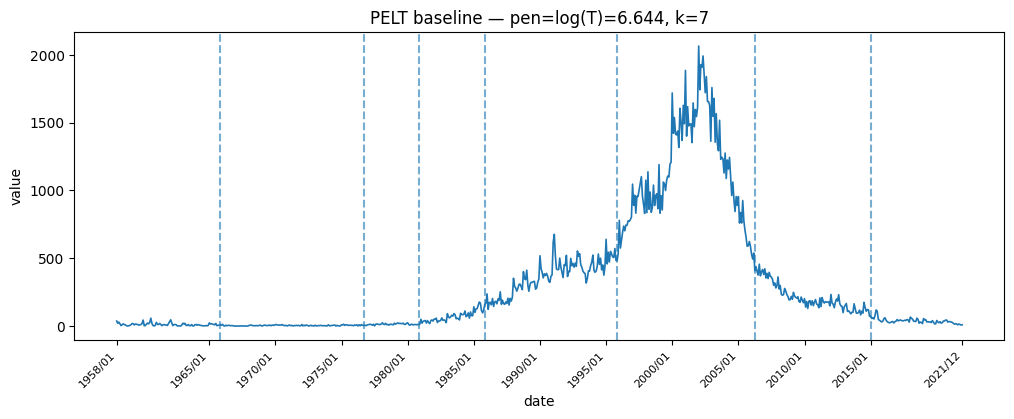

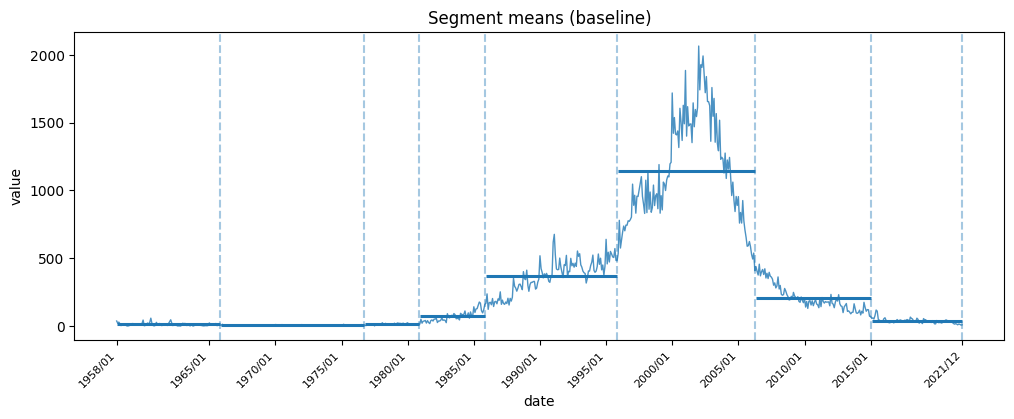

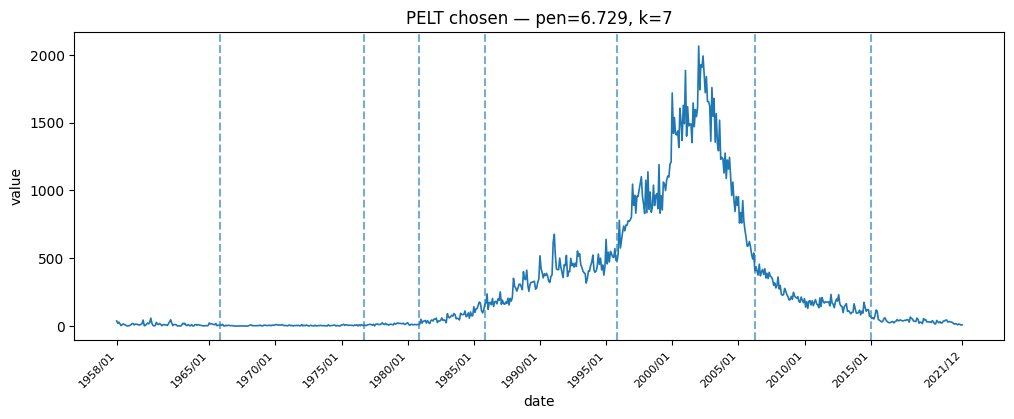

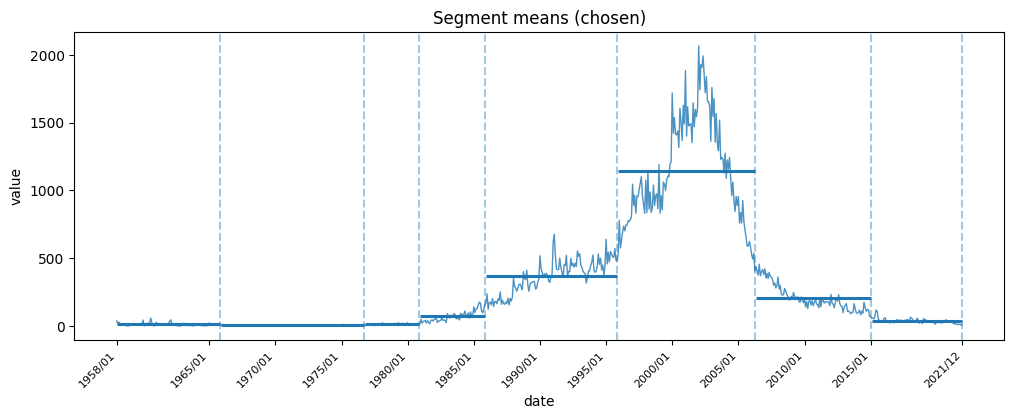

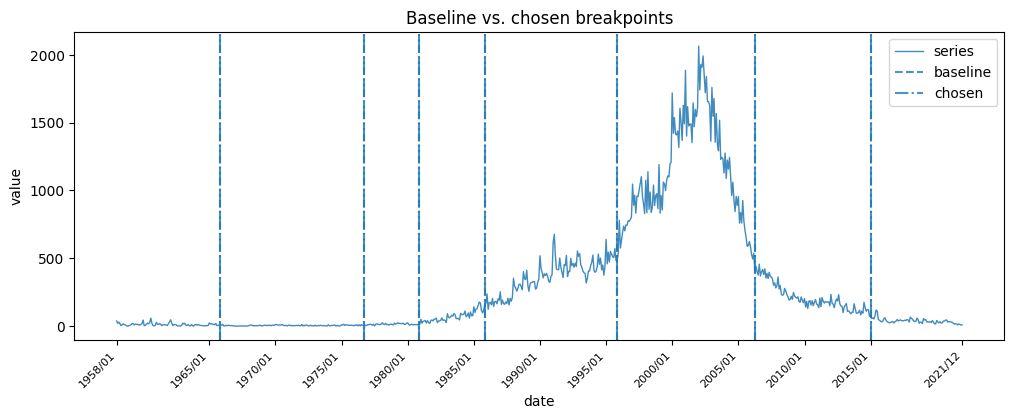

In [ ]:
# ============================================================
# PELT + CROPS-like sweep with better penalty selection
# ============================================================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator
import ruptures as rpt

# ---------------------------------------------------------------------
# X/Y preparation (works with numeric or datetime x)
# ---------------------------------------------------------------------
def _coerce_x(x):
    """Return (x_1d, is_datetime). Ensure 1D and coerce to datetime if possible."""
    if isinstance(x, (pd.Series, pd.DatetimeIndex)):
        arr = x.to_numpy()
    else:
        arr = np.asarray(x)

    if arr.ndim > 1:
        arr = np.squeeze(arr)
    if arr.ndim != 1:
        raise ValueError(f"x must be 1D after squeezing; got shape {arr.shape}")

    if arr.dtype == object:
        try:
            arr = pd.to_datetime(arr).to_numpy()
            return arr, True
        except Exception:
            return arr, False

    if np.issubdtype(arr.dtype, np.datetime64):
        return arr, True

    return arr, False


def _prepare_xy(y, x):
    """If y is a Series with DatetimeIndex and x is None, use y.index as x."""
    y_arr = y.values if isinstance(y, pd.Series) else np.asarray(y)
    if x is None and isinstance(y, pd.Series) and isinstance(y.index, pd.DatetimeIndex):
        x_arr, x_is_dt = _coerce_x(y.index)
    elif x is None:
        x_arr = np.arange(len(y_arr))
        x_is_dt = False
    else:
        x_arr, x_is_dt = _coerce_x(x)
    if len(x_arr) != len(y_arr):
        raise ValueError(f"x and y must have same length; got {len(x_arr)} vs {len(y_arr)}")
    return y_arr, x_arr, x_is_dt


# ---------------------------------------------------------------------
# Plotting (expects your compute_time_ticks / apply_time_ticks if using ticks)
# ---------------------------------------------------------------------
def plot_with_bkps(
    y, bkps, *, x=None, title="Series with change points",
    ticks=None, tick_fmt="%Y/%m", tick_rotation=45, tick_font_size=8
):
    y_arr, x_arr, x_is_dt = _prepare_xy(y, x)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_arr, y_arr, lw=1.2)
    for b in bkps[:-1]:
        if 0 <= b-1 < len(x_arr):
            ax.axvline(x_arr[b-1], ls="--", alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("date" if x_is_dt else "t")
    ax.set_ylabel("value")
    if ticks is not None and x_is_dt:
        apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)
    plt.show()


def plot_segment_means(
    y, bkps, *, x=None, title="Segment means",
    ticks=None, tick_fmt="%Y/%m", tick_rotation=45, tick_font_size=8
):
    y_arr, x_arr, x_is_dt = _prepare_xy(y, x)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_arr, y_arr, lw=1.0, alpha=0.8)
    start = 0
    for end in bkps:
        end = int(end)
        if end > start:
            mu = float(np.mean(y_arr[start:end]))
            ax.hlines(mu, x_arr[start], x_arr[end-1], lw=2.2)
            ax.axvline(x_arr[end-1], ls="--", alpha=0.4)
        start = end
    ax.set_title(title)
    ax.set_xlabel("date" if x_is_dt else "t")
    ax.set_ylabel("value")
    if ticks is not None and x_is_dt:
        apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)
    plt.show()


def plot_compare_bkps(
    y, bkps_a, bkps_b, *, x=None, label_a="baseline", label_b="chosen",
    ticks=None, tick_fmt="%Y/%m", tick_rotation=45, tick_font_size=8
):
    y_arr, x_arr, x_is_dt = _prepare_xy(y, x)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_arr, y_arr, lw=1.0, alpha=0.85, label="series")
    for i, b in enumerate(bkps_a[:-1]):
        if 0 <= b-1 < len(x_arr):
            ax.axvline(x_arr[b-1], ls="--", alpha=0.8, label=label_a if i == 0 else None)
    for i, b in enumerate(bkps_b[:-1]):
        if 0 <= b-1 < len(x_arr):
            ax.axvline(x_arr[b-1], ls="-.", alpha=0.8, label=label_b if i == 0 else None)
    ax.set_title("Baseline vs. chosen breakpoints")
    ax.set_xlabel("date" if x_is_dt else "t")
    ax.set_ylabel("value")
    ax.legend()
    if ticks is not None and x_is_dt:
        apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)
    plt.show()


# ---------------------------------------------------------------------
# Cost summaries
# ---------------------------------------------------------------------
def segmentation_cost_summary(cost, bkps, pen):
    k = len(bkps) - 1
    unpen = cost.sum_of_costs(bkps)
    pcost = unpen + pen * k
    return {"k": k, "unpenalized": unpen, "penalized": pcost, "pen": pen}


# ---------------------------------------------------------------------
# CROPS-like sweep (linear grid) + BETTER penalty selection
# ---------------------------------------------------------------------
def crops_like_pen_sweep(y2d, cost, pen_min, pen_max, n=30):
    """
    Linear sweep of penalties in [pen_min, pen_max]. Collect unique optimal segmentations.
    Returns: list of dicts with fields: 'pen', 'bkps', 'k', 'cost', 'pcost'
    """
    algo = rpt.Pelt(model="custom", custom_cost=cost).fit(y2d)
    pens = np.linspace(pen_min, pen_max, int(n))
    seen = set()
    out = []
    for p in pens:
        bkps = tuple(algo.predict(pen=float(p)))
        if bkps not in seen:
            seen.add(bkps)
            k = len(bkps) - 1
            unpen = cost.sum_of_costs(list(bkps))
            pcost = unpen + p * k
            out.append({"pen": float(p), "bkps": list(bkps), "k": k,
                        "cost": float(unpen), "pcost": float(pcost)})
    out.sort(key=lambda d: d["pen"])
    return out


# ---------- Penalty selection strategies ----------
from itertools import groupby

def _bkps_key(d):
    return tuple(d["bkps"])

def select_by_penalized_cost(results):
    """Statistically principled: minimize penalized cost."""
    if not results:
        raise ValueError("Empty results.")
    return min(results, key=lambda d: d["pcost"])

def select_bic_like(results, T):
    """Pick the solution whose penalty is closest to log(T)."""
    if not results:
        raise ValueError("Empty results.")
    target = math.log(T)
    return min(results, key=lambda d: abs(d["pen"] - target))

def select_by_knee_biggest_drop(results):
    """Elbow on k vs pen: choose the solution AFTER the largest drop in k."""
    if not results:
        raise ValueError("Empty results.")
    if len(results) == 1:
        return results[0]
    res = sorted(results, key=lambda d: d["pen"])
    best_idx, best_score = 0, -1
    for i in range(len(res) - 1):
        dp = res[i+1]["pen"] - res[i]["pen"]
        if dp <= 0:
            continue
        dk = res[i]["k"] - res[i+1]["k"]  # drop in k
        score = dk / dp
        if score > best_score:
            best_score, best_idx = score, i
    return res[min(best_idx + 1, len(res) - 1)]

def select_by_stability_plateau(results):
    """
    Group consecutive identical segmentations; choose the plateau
    with the widest penalty span, and return its center solution.
    """
    if not results:
        raise ValueError("Empty results.")
    res = sorted(results, key=lambda d: d["pen"])
    plateaus = []
    for key, grp in groupby(res, key=_bkps_key):
        g = list(grp)
        span = g[-1]["pen"] - g[0]["pen"]
        plateaus.append((span, g))
    plateaus.sort(key=lambda t: t[0], reverse=True)
    _, best_group = plateaus[0]
    return best_group[len(best_group) // 2]

def select_by_target_k(results, k_target):
    """Choose the k closest to k_target; break ties by lower penalized cost."""
    if not results:
        raise ValueError("Empty results.")
    return min(results, key=lambda d: (abs(d["k"] - k_target), d["pcost"]))

def choose_penalty(results, T, *, strategy="stable", k_target=None):
    """
    Unified selector. strategy in {"pcost", "bic", "knee", "stable", "target_k"}.
    Default: "stable" (robust to the exact penalty value).
    """
    s = strategy.lower()
    if s == "pcost":
        return select_by_penalized_cost(results)
    if s == "bic":
        return select_bic_like(results, T)
    if s == "knee":
        return select_by_knee_biggest_drop(results)
    if s == "stable":
        return select_by_stability_plateau(results)
    if s == "target_k":
        if k_target is None:
            raise ValueError("k_target is required for strategy='target_k'.")
        return select_by_target_k(results, k_target)
    raise ValueError(f"Unknown strategy: {strategy}")


# ---------------------------------------------------------------------
# Example pipeline (plug this into your notebook/script)
# ---------------------------------------------------------------------
# y: np.array of your indicator values
y = np.array(dfDataOrig[idIndicatorViolence].values.tolist())
T = len(y)
print(f"T={T}, min={y.min():.3f}, max={y.max():.3f}, mean={y.mean():.3f}")

# Fit NB2 cost (global r via method-of-moments) – assumes your functions exist
r_hat = estimate_r_nb2_global(y)
print(f"Estimated global r (NB2, moments): {r_hat:.4f}")

y2d = y.reshape(-1, 1)
cost = CostNegBinomial(r=r_hat, min_size=5).fit(y2d)

# Baseline run at pen = log(T)
pen0 = math.log(T)
bkps0 = rpt.Pelt(model="custom", custom_cost=cost).fit(y2d).predict(pen=pen0)
print("Single-run bkps (pen=log(T)):", bkps0, "| #changes:", len(bkps0) - 1)

# CROPS-like sweep
pen_min = 0.5 * math.log(T)
pen_max = 3.0 * math.log(T)

results = crops_like_pen_sweep(y2d, cost, pen_min, pen_max, n=40)
print(f"\nCROPS-like sweep collected {len(results)} unique optimal segmentations.")
for r in results[:8]:
    print(f"pen={r['pen']:.3f} -> k={r['k']}, bkps(head)={r['bkps'][:4]} ...")
if len(results) > 8:
    print("...")

# Visualize k vs pen
plt.figure(figsize=(10, 3.5))
plt.plot([d["pen"] for d in results], [d["k"] for d in results], marker="o")
plt.xlabel("penalty")
plt.ylabel("# changes")
plt.title("# changes vs penalty (CROPS-like sweep)")
plt.grid(True)
plt.show()

# strategy can be: "stable" (default), "pcost", "bic", "knee", or "target_k"
chosen = choose_penalty(results, T, strategy="bic")   # or strategy="pcost"/"bic"/"knee"/"target_k"
print(f"\nChosen (strategy=stable): pen={chosen['pen']:.3f} -> k={chosen['k']}, bkps={chosen['bkps']}")

# Compare costs against baseline
base_sum = segmentation_cost_summary(cost, bkps0, pen0)
chosen_sum = segmentation_cost_summary(cost, chosen["bkps"], chosen["pen"])
print("\nCost summary:")
print(f"Baseline: k={base_sum['k']}, pen={base_sum['pen']:.3f}, "
      f"unpen={base_sum['unpenalized']:.3f}, penalized={base_sum['penalized']:.3f}")
print(f"Chosen:   k={chosen_sum['k']}, pen={chosen_sum['pen']:.3f}, "
      f"unpen={chosen_sum['unpenalized']:.3f}, penalized={chosen_sum['penalized']:.3f}")

# ----- Plots (baseline vs chosen) -----
date_col = "period"
x_dates = pd.to_datetime(df[date_col].to_numpy())  # ensure 1D datetime array
start_dt, end_dt = x_dates[0], x_dates[-1]
ticks = compute_time_ticks(start_dt, end_dt, year_interval=5, include_edges=True)

# Baseline
plot_with_bkps(y, bkps0, x=x_dates, ticks=ticks,
               title=f"PELT baseline — pen=log(T)={pen0:.3f}, k={len(bkps0)-1}")
plot_segment_means(y, bkps0, x=x_dates, ticks=ticks, title="Segment means (baseline)")

# Chosen
plot_with_bkps(y, chosen["bkps"], x=x_dates, ticks=ticks,
               title=f"PELT chosen — pen={chosen['pen']:.3f}, k={chosen['k']}")
plot_segment_means(y, chosen["bkps"], x=x_dates, ticks=ticks, title="Segment means (chosen)")

# Compare
plot_compare_bkps(y, bkps0, chosen["bkps"], x=x_dates, ticks=ticks,
                  label_a="baseline", label_b="chosen")


<>:211: SyntaxWarning: invalid escape sequence '\S'
<>:211: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2982755793.py:211: SyntaxWarning: invalid escape sequence '\S'
  print("\Sweep around log(T):")


T=768, min=0.000, max=2064.000, mean=284.128
Estimated global r (NB2, moments): 0.4322
Single-run bkps (pen=log(T)=6.644): [95, 225, 275, 335, 455, 580, 685, 768] | #changes: 7
\Sweep around log(T):
pen=4.651 -> k=8, bkps(head)=[105, 120, 235, 300, 360, 460]...
pen=6.644 -> k=7, bkps(head)=[95, 225, 275, 335, 455, 580]...
pen=7.640 -> k=5, bkps(head)=[275, 335, 455, 580, 685, 768]


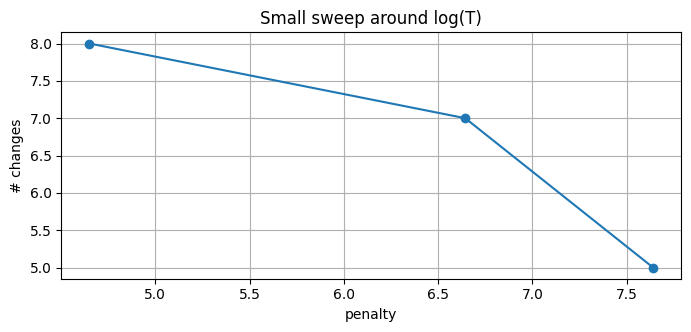

/tmp/ipython-input-2982755793.py:220: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_dates = pd.to_datetime(df[date_col].to_numpy())  # ensure 1D datetime array


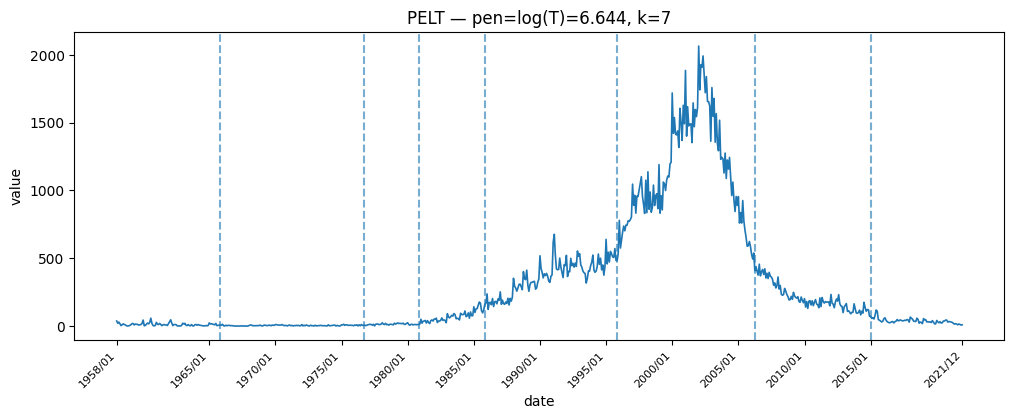

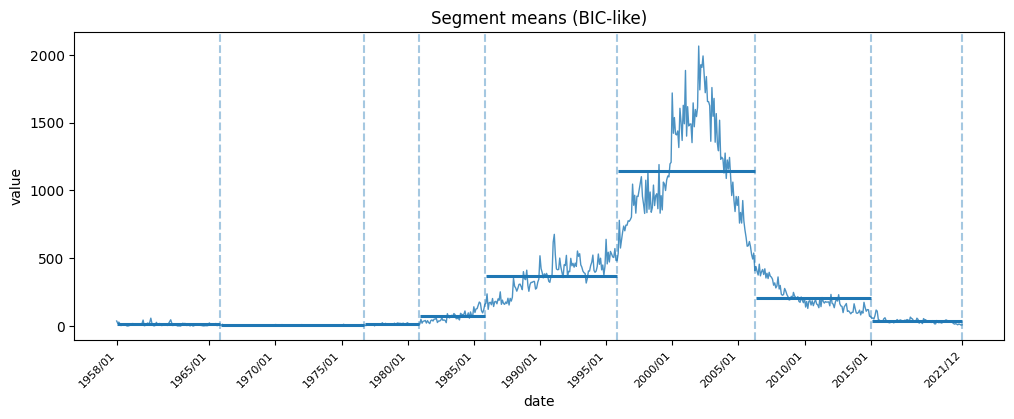

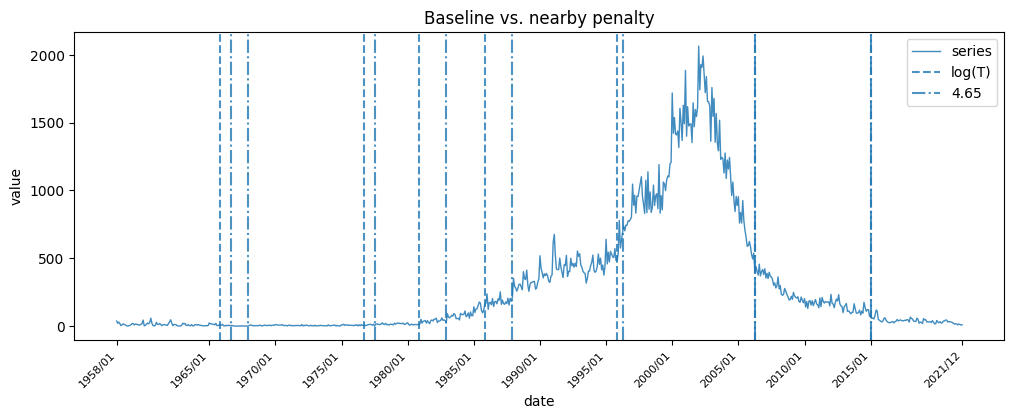

In [ ]:
# ============================================================
# PELT with BIC-like penalty (log T) + small robustness sweep
# ============================================================
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator
import ruptures as rpt

# ---------------------------------------------------------------------
# X/Y preparation (works with numeric or datetime x)
# ---------------------------------------------------------------------
def _coerce_x(x):
    """Return (x_1d, is_datetime). Ensure 1D and coerce to datetime if possible."""
    if isinstance(x, (pd.Series, pd.DatetimeIndex)):
        arr = x.to_numpy()
    else:
        arr = np.asarray(x)

    if arr.ndim > 1:
        arr = np.squeeze(arr)
    if arr.ndim != 1:
        raise ValueError(f"x must be 1D after squeezing; got shape {arr.shape}")

    if arr.dtype == object:
        try:
            arr = pd.to_datetime(arr).to_numpy()
            return arr, True
        except Exception:
            return arr, False

    if np.issubdtype(arr.dtype, np.datetime64):
        return arr, True

    return arr, False


def _prepare_xy(y, x):
    """If y is a Series with DatetimeIndex and x is None, use y.index as x."""
    y_arr = y.values if isinstance(y, pd.Series) else np.asarray(y)
    if x is None and isinstance(y, pd.Series) and isinstance(y.index, pd.DatetimeIndex):
        x_arr, x_is_dt = _coerce_x(y.index)
    elif x is None:
        x_arr = np.arange(len(y_arr))
        x_is_dt = False
    else:
        x_arr, x_is_dt = _coerce_x(x)
    if len(x_arr) != len(y_arr):
        raise ValueError(f"x and y must have same length; got {len(x_arr)} vs {len(y_arr)}")
    return y_arr, x_arr, x_is_dt


# ---------------------------------------------------------------------
# Plotting (expects your compute_time_ticks / apply_time_ticks if using ticks)
# ---------------------------------------------------------------------
def plot_with_bkps(
    y, bkps, *, x=None, title="Series with change points",
    ticks=None, tick_fmt="%Y/%m", tick_rotation=45, tick_font_size=8
):
    y_arr, x_arr, x_is_dt = _prepare_xy(y, x)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_arr, y_arr, lw=1.2)
    for b in bkps[:-1]:
        if 0 <= b-1 < len(x_arr):
            ax.axvline(x_arr[b-1], ls="--", alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("date" if x_is_dt else "t")
    ax.set_ylabel("value")
    if ticks is not None and x_is_dt:
        apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)
    plt.show()


def plot_segment_means(
    y, bkps, *, x=None, title="Segment means",
    ticks=None, tick_fmt="%Y/%m", tick_rotation=45, tick_font_size=8
):
    y_arr, x_arr, x_is_dt = _prepare_xy(y, x)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_arr, y_arr, lw=1.0, alpha=0.8)
    start = 0
    for end in bkps:
        end = int(end)
        if end > start:
            mu = float(np.mean(y_arr[start:end]))
            ax.hlines(mu, x_arr[start], x_arr[end-1], lw=2.2)
            ax.axvline(x_arr[end-1], ls="--", alpha=0.4)
        start = end
    ax.set_title(title)
    ax.set_xlabel("date" if x_is_dt else "t")
    ax.set_ylabel("value")
    if ticks is not None and x_is_dt:
        apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)
    plt.show()


def plot_compare_bkps(
    y, bkps_a, bkps_b, *, x=None, label_a="baseline", label_b="nearby",
    ticks=None, tick_fmt="%Y/%m", tick_rotation=45, tick_font_size=8
):
    y_arr, x_arr, x_is_dt = _prepare_xy(y, x)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_arr, y_arr, lw=1.0, alpha=0.85, label="series")
    for i, b in enumerate(bkps_a[:-1]):
        if 0 <= b-1 < len(x_arr):
            ax.axvline(x_arr[b-1], ls="--", alpha=0.8, label=label_a if i == 0 else None)
    for i, b in enumerate(bkps_b[:-1]):
        if 0 <= b-1 < len(x_arr):
            ax.axvline(x_arr[b-1], ls="-.", alpha=0.8, label=label_b if i == 0 else None)
    ax.set_title("Baseline vs. nearby penalty")
    ax.set_xlabel("date" if x_is_dt else "t")
    ax.set_ylabel("value")
    ax.legend()
    if ticks is not None and x_is_dt:
        apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)
    plt.show()


# ---------------------------------------------------------------------
# Cost summaries
# ---------------------------------------------------------------------
def segmentation_cost_summary(cost, bkps, pen):
    k = len(bkps) - 1
    unpen = cost.sum_of_costs(bkps)
    pcost = unpen + pen * k
    return {"k": k, "unpenalized": unpen, "penalized": pcost, "pen": pen}


# ---------------------------------------------------------------------
# PELT at BIC-like beta = log(T) + small robustness sweep
# ---------------------------------------------------------------------
def run_pelt_logT(y2d, cost):
    """Run PELT once with beta = log(T). Return (pen0, bkps0, k0)."""
    T = y2d.shape[0]
    pen0 = math.log(T)
    algo = rpt.Pelt(model="custom", custom_cost=cost).fit(y2d)
    bkps0 = algo.predict(pen=pen0)
    k0 = len(bkps0) - 1
    return pen0, bkps0, k0


def sweep_around_logT(y2d, cost, *, T=None, multipliers=(0.8, 1.0, 1.25)):
    """
    Run a small sweep around log(T) to check robustness.
    Returns a list of dicts: [{'pen', 'bkps', 'k', 'cost', 'pcost'}, ...] sorted by 'pen'.
    """
    if T is None:
        T = y2d.shape[0]
    beta0 = math.log(T)

    algo = rpt.Pelt(model="custom", custom_cost=cost).fit(y2d)
    out = []
    seen = set()
    for m in multipliers:
        pen = float(m * beta0)
        bkps = tuple(algo.predict(pen=pen))
        if bkps in seen:
            continue
        seen.add(bkps)
        k = len(bkps) - 1
        unpen = cost.sum_of_costs(list(bkps))
        pcost = unpen + pen * k
        out.append({"pen": pen, "bkps": list(bkps), "k": k, "cost": float(unpen), "pcost": float(pcost)})
    out.sort(key=lambda d: d["pen"])
    return out


def plot_small_sweep(results, *, title="Small sweep around log(T)"):
    """Plot #changes vs penalty for the small sweep."""
    if not results:
        print("No sweep results to plot.")
        return
    pens = [r["pen"] for r in results]
    ks = [r["k"] for r in results]
    plt.figure(figsize=(8, 3.2))
    plt.plot(pens, ks, marker="o")
    plt.xlabel("penalty")
    plt.ylabel("# changes")
    plt.title(title)
    plt.grid(True)
    plt.show()


# ---------------------------------------------------------------------
# Example pipeline (plug this into your notebook/script)
# ---------------------------------------------------------------------
# y: np.array of your indicator values (counts or whatever your cost expects)
y = np.array(dfDataOrig[idIndicatorViolence].values.tolist())
T = len(y)
print(f"T={T}, min={y.min():.3f}, max={y.max():.3f}, mean={y.mean():.3f}")

# Fit NB2 cost (global r via method-of-moments) – assumes your functions exist:
#   - estimate_r_nb2_global(y)
#   - CostNegBinomial(r=..., min_size=...).fit(y2d)
r_hat = estimate_r_nb2_global(y)
print(f"Estimated global r (NB2, moments): {r_hat:.4f}")

y2d = y.reshape(-1, 1)
cost = CostNegBinomial(r=r_hat, min_size=5).fit(y2d)

#  PELT @ BIC-like beta = log(T)
pen0, bkps0, k0 = run_pelt_logT(y2d, cost)
print(f"Single-run bkps (pen=log(T)={pen0:.3f}): {bkps0} | #changes: {k0}")

# --- Small robustness sweep around log(T) ---
#   Adjust multipliers as you like (e.g., (0.7, 0.85, 1.0, 1.15, 1.3))
#sweep_results = sweep_around_logT(y2d, cost, T=T, multipliers=(0.8, 1.0, 1.25))
sweep_results = sweep_around_logT(y2d, cost, T=T, multipliers=(0.7, 0.85, 1.0, 1.15, 1.3))
print("\Sweep around log(T):")
for r in sweep_results:
    print(f"pen={r['pen']:.3f} -> k={r['k']}, bkps(head)={r['bkps'][:6]}{'...' if len(r['bkps'])>6 else ''}")

# Optional: visualize the small sweep
plot_small_sweep(sweep_results)

# ----- Plots for the baseline (and optional comparison) -----
date_col = "period"
x_dates = pd.to_datetime(df[date_col].to_numpy())  # ensure 1D datetime array
start_dt, end_dt = x_dates[0], x_dates[-1]
ticks = compute_time_ticks(start_dt, end_dt, year_interval=5, include_edges=True)

# Baseline plots at pen = log(T)
plot_with_bkps(y, bkps0, x=x_dates, ticks=ticks,
               title=f"PELT — pen=log(T)={pen0:.3f}, k={k0}")
plot_segment_means(y, bkps0, x=x_dates, ticks=ticks, title="Segment means (BIC-like)")

# If you want to visually compare to a nearby penalty from the sweep (optional):
if len(sweep_results) > 1:
    # pick the nearest to log(T) that's different from baseline, if any
    near = None
    for r in sweep_results:
        if tuple(r["bkps"]) != tuple(bkps0):
            near = r
            break
    if near is not None:
        plot_compare_bkps(y, bkps0, near["bkps"], x=x_dates, ticks=ticks,
                          label_a="log(T)", label_b=f"{near['pen']:.2f}")


Conservative choice: pen=7.640, k=5, bkps=[275, 335, 455, 580, 685, 768]
BIC-like: pen=6.644, k=7, bkps=[95, 225, 275, 335, 455, 580, 685, 768]
Segment lengths (conservative): [275, 60, 120, 125, 105, 83]
Segment means   (conservative): ['8.29', '71.07', '365.77', '1142.55', '208.48', '36.92']


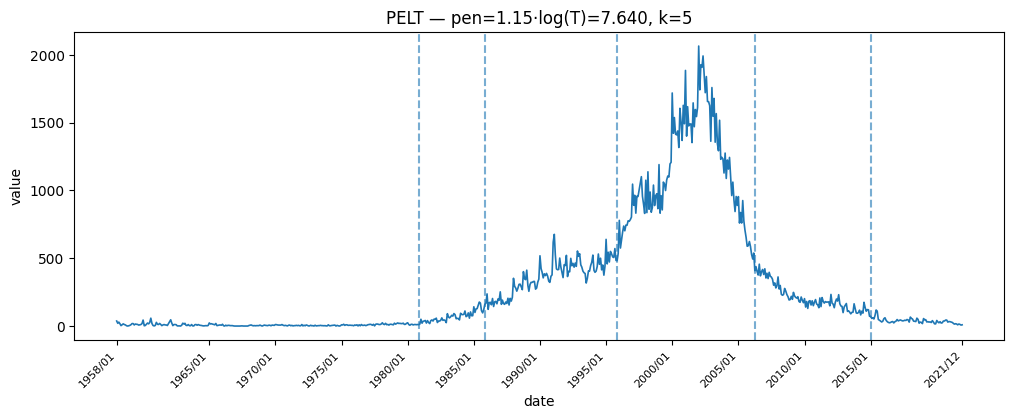

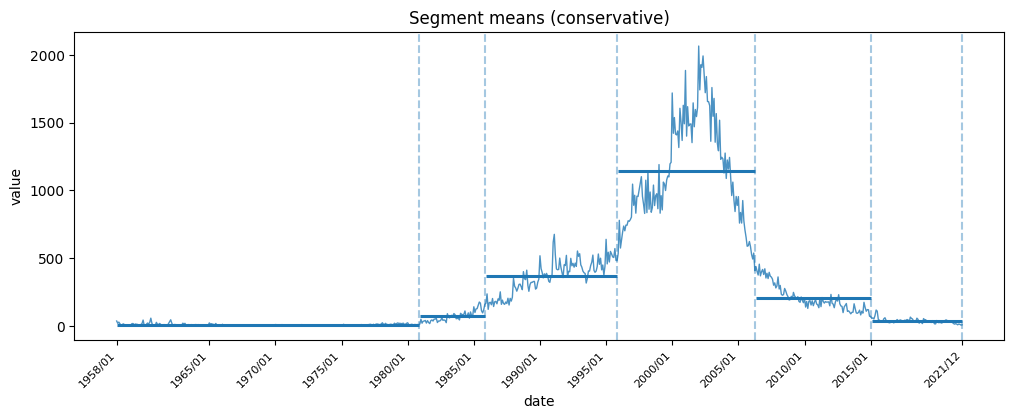

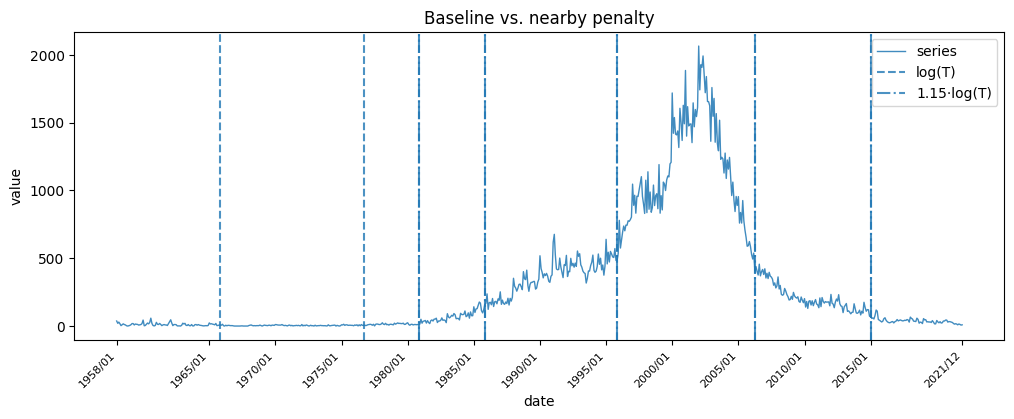

In [ ]:
import math
import numpy as np

# --- 1) Ejecutar PELT con la penalización conservadora: 1.15 * log(T) ---
T = len(y2d)
beta0 = math.log(T)
pen_conservative = 1.15 * beta0

algo = rpt.Pelt(model="custom", custom_cost=cost).fit(y2d)
bkps_conservative = algo.predict(pen=pen_conservative)
k_conservative = len(bkps_conservative) - 1
print(f"Conservative choice: pen={pen_conservative:.3f}, k={k_conservative}, bkps={bkps_conservative}")

# --- 2) (Opcional) Comparar con la solución BIC-like log(T) ---
pen_bic = beta0
bkps_bic = algo.predict(pen=pen_bic)
print(f"BIC-like: pen={pen_bic:.3f}, k={len(bkps_bic)-1}, bkps={bkps_bic}")

# --- 3) Resumen de longitudes y medias por segmento (para la elección final) ---
def segment_stats(y, bkps):
    starts = [0] + bkps[:-1]
    ends   = bkps
    lengths = [e - s for s, e in zip(starts, ends)]
    means   = [float(np.mean(y[s:e])) if e > s else float("nan") for s, e in zip(starts, ends)]
    return lengths, means

lengths_c, means_c = segment_stats(y, bkps_conservative)
print("Segment lengths (conservative):", lengths_c)
print("Segment means   (conservative):", [f"{m:.2f}" for m in means_c])

# --- 4) Graficar la elección conservadora ---
# Asumiendo que ya tienes x_dates, ticks y las funciones de ploteo
plot_with_bkps(y, bkps_conservative, x=x_dates, ticks=ticks,
               title=f"PELT — pen=1.15·log(T)={pen_conservative:.3f}, k={k_conservative}")
plot_segment_means(y, bkps_conservative, x=x_dates, ticks=ticks,
                   title="Segment means (conservative)")

# --- 5) (Opcional) Comparar visualmente con log(T) ---
plot_compare_bkps(y, bkps_bic, bkps_conservative, x=x_dates, ticks=ticks,
                  label_a="log(T)", label_b="1.15·log(T)")


In [ ]:
chosen

{'pen': 6.728966524598285,
 'bkps': [95, 225, 275, 335, 455, 580, 685, 768],
 'k': 7,
 'cost': 2018.855806673889,
 'pcost': 2065.958572346077}

In [ ]:
import math
import numpy as np
from ruptures.base import BaseCost

class CostNegBinomialOffset(BaseCost):
    """
    NB2 segment cost with an exposure (offset). Signal columns:
      col0: counts Y_t >= 0
      col1: exposure E_t > 0  (e.g., population or population in millions)
    Model:
      Y_t ~ NB2(mu_t, r),   mu_t = lambda * E_t,   r = global dispersion (fixed)
    Segment parameter: lambda (rate per unit exposure)

    Segment cost = -loglik evaluated at lambda_hat (MLE), ignoring constants
    that cancel across segmentations.

    We solve for lambda_hat with a safeguarded 1D root finding on the derivative
    of the negative log-likelihood.

    Conventions:
      - If sum(Y)=0 over the segment -> cost = 0 (correct limit)
      - min_size controls the minimum segment length
    """
    model = "nb2_offset"

    def __init__(self, r=5.0, min_size=2, jump=1, tol=1e-10, max_iter=60):
        if r <= 0:
            raise ValueError("Dispersion parameter r must be positive.")
        self.r = float(r)
        self.min_size = int(min_size)
        self.jump = int(jump)
        self.tol = float(tol)
        self.max_iter = int(max_iter)
        # internals
        self.signal = None
        self.y = None
        self.e = None
        self.cum_y = None
        self.cum_e = None

    def fit(self, signal):
        """
        signal: array-like of shape (T, 2); columns = [Y_t, E_t]
        Y_t: counts (>=0), E_t: exposure (>0)
        """
        arr = np.asarray(signal, dtype=float)
        if arr.ndim != 2 or arr.shape[1] != 2:
            raise ValueError("Signal must be 2D with 2 columns: [counts, exposure].")
        if np.any(arr[:, 0] < 0):
            raise ValueError("Found negative counts; expected Y >= 0.")
        if np.any(arr[:, 1] <= 0):
            raise ValueError("Found non-positive exposures; expected E > 0.")

        self.signal = arr
        self.y = arr[:, 0]
        self.e = arr[:, 1]
        self.cum_y = np.concatenate(([0.0], np.cumsum(self.y)))
        self.cum_e = np.concatenate(([0.0], np.cumsum(self.e)))
        return self

    # ---------- core: per-segment optimization ----------
    def _negloglik_and_grad(self, lam, y_seg, e_seg, r):
        """
        Negative log-likelihood (up to constants that cancel across segmentations)
        and its derivative wrt lambda for NB2 with mu_t = lambda * E_t.

        Stable form for the negative log-likelihood (dropping global constants):
          f(lambda) = sum_t [ (r + y_t) * log(1 + (lambda * e_t)/r) + y_t * log(r/lambda) ]
        Note: the sum(y_t * log r) term is constant overall; keeping it doesn't
        affect segmentation, but we keep y*log(r/lambda) for simplicity.

        Gradient (derivative wrt lambda):
          f'(lambda) = sum_t [ (r + y_t) * e_t / (r + lambda*e_t) - y_t / lambda ]
        """
        re = lam * e_seg
        print('re'+str(re))
        # negative loglik
        f = np.sum((r + y_seg) * np.log1p(re / r) + y_seg * (math.log(r) - math.log(lam)))
        # gradient
        g = np.sum((r + y_seg) * (e_seg / (r + re)) - y_seg / lam)
        return f, g

    def _find_lambda_hat(self, y_seg, e_seg, r, lam0=None):
        """
        Safeguarded 1D root finding on the gradient to get lambda_hat.
        Starts from lam0 or the Poisson offset MLE S_Y / S_E, and finds a bracket
        where grad changes sign, then bisection with a few Newton steps.
        """
        S_Y = float(y_seg.sum())
        S_E = float(e_seg.sum())
        if S_Y <= 0.0 or S_E <= 0.0:
            return 0.0

        # Initial guess: Poisson-offset MLE
        lam = float(S_Y / S_E) if (lam0 is None or lam0 <= 0) else float(lam0)
        lam = max(lam, 1e-12)
        print(lam)

        # Helper: gradient at lambda
        def grad(lmb):
            _, g = self._negloglik_and_grad(lmb, y_seg, e_seg, r)
            return g

        g0 = grad(lam)
        if abs(g0) < self.tol:
            return lam

        # Bracket search: expand until gradient changes sign
        L, U = lam, lam
        gL, gU = g0, g0
        # Try expanding upwards
        for _ in range(30):
            U *= 2.0
            gU = grad(U)
            if gL * gU <= 0:  # sign change
                break
        # If no sign change upwards, expand downwards
        if gL * gU > 0:
            L = lam
            gL = g0
            U = lam
            gU = g0
            for _ in range(30):
                L *= 0.5
                if L < 1e-16:
                    L = 1e-16
                gL = grad(L)
                if gL * gU <= 0:
                    break

        # If still no bracket, fall back to positive lambda from Poisson MLE
        if gL * gU > 0:
            # As a fallback, do a few damped Newton steps from lam
            lmb = lam
            for _ in range(self.max_iter):
                f, g = self._negloglik_and_grad(lmb, y_seg, e_seg, r)
                # approximate Hessian (second derivative)
                # f'' ≈ sum[ -(r+y) * (e^2)/(r+lam*e)^2 + y/lam^2 ]
                h = np.sum(-(r + y_seg) * (e_seg**2) / (r + lmb * e_seg)**2 + y_seg / (lmb**2))
                # avoid division by zero
                if abs(h) < 1e-16:
                    break
                step = -g / h
                # backtracking
                t = 1.0
                for _ in range(10):
                    cand = lmb + t * step
                    if cand > 0:
                        f_cand, _ = self._negloglik_and_grad(cand, y_seg, e_seg, r)
                        if f_cand <= f:  # accept if decreased
                            lmb = cand
                            break
                    t *= 0.5
                if abs(g) < self.tol:
                    return max(lmb, 1e-12)
            return max(lmb, 1e-12)

        # Bisection within [L, U]
        a, b = min(L, U), max(L, U)
        ga, gb = grad(a), grad(b)
        for _ in range(self.max_iter):
            m = 0.5 * (a + b)
            gm = grad(m)
            if abs(gm) < self.tol:
                return max(m, 1e-12)
            # keep sign change interval
            if ga * gm <= 0:
                b, gb = m, gm
            else:
                a, ga = m, gm
            if (b - a) / max(1.0, m) < 1e-10:
                break
        return max(0.5 * (a + b), 1e-12)

    # ---------- ruptures API ----------
    def error(self, start, end):
        """
        Return the segment cost for [start, end).
        """
        n = end - start
        if n < self.min_size:
            return np.inf

        y_seg = self.y[start:end]
        e_seg = self.e[start:end]
        S_Y = float(y_seg.sum())
        if S_Y <= 0.0:
            return 0.0  # all zeros -> limit cost 0

        lam_hat = self._find_lambda_hat(y_seg, e_seg, self.r)
        print('lam_hat:'+str(lam_hat))
        # Evaluate negative log-likelihood (up to global constants)
        f, _ = self._negloglik_and_grad(lam_hat, y_seg, e_seg, self.r)
        return float(f)

    def sum_of_costs(self, bkps):
        start = 0
        total = 0.0
        for end in bkps:
            total += self.error(start, end)
            start = end
        return total

In [ ]:
def estimate_r_nb2_global_from_counts(y):
    y = np.asarray(y, dtype=float).reshape(-1)
    mu = y.mean()
    var = y.var(ddof=1) if y.size > 1 else 0.0
    if mu > 0 and var > mu:
        print('Overdispersion')
        return float(max((mu*mu) / (var - mu), 1e-6))
    else:
        return 1e6  # casi Poisson si no hay sobredispersión


In [ ]:
import pandas as pd
import numpy as np

# --- Census years and annual estimates (anchor points) ---
data = {
    "year": [1951, 1964, 1973, 1985, 1993, 2005, 2018, 2019, 2020, 2021],
    "population": [11548172, 17484510, 20666920, 27853432,
                   33109839, 41468384, 48258494, 49395678,
                   50372424, 51049498]
}
df_year = pd.DataFrame(data)
# Build a timestamp at January 1st of each anchor year and set it as the index
df_year["date"] = pd.to_datetime(df_year["year"].astype(str) + "-01-01")
df_year = df_year.set_index("date")[["population"]].sort_index()

# --- 1) Monthly interpolation between the first and last available anchors ---
# Use the full range 1951-01 to 2021-01 so months like 1958–1963 have a previous anchor (1951).
full_monthly_idx = pd.date_range(df_year.index.min(), df_year.index.max(), freq="MS")
# Reindex to monthly and interpolate in time to fill the gaps
df_full = df_year.reindex(full_monthly_idx).interpolate(method="time")

# --- 2) Linearly extend from 2021-02 to 2021-12 using the most recent annual increment ---
# Compute the last observed annual increment: population(2021-01) - population(2020-01)
p_2020 = df_year.loc[pd.Timestamp("2020-01-01"), "population"]
p_2021 = df_year.loc[pd.Timestamp("2021-01-01"), "population"]
annual_inc_last = p_2021 - p_2020
monthly_inc_last = annual_inc_last / 12.0

# Build the extension index (Feb→Dec 2021) and values by adding the monthly increment
ext_idx = pd.date_range("2021-02-01", "2021-12-01", freq="MS")
start_val = df_full.loc[pd.Timestamp("2021-01-01"), "population"]
ext_vals = start_val + monthly_inc_last * np.arange(1, len(ext_idx) + 1)
df_ext = pd.DataFrame({"population": ext_vals}, index=ext_idx)

# Combine interpolation (up to 2021-01) with the linear extension (2021-02→2021-12)
df_monthly_all = pd.concat([df_full, df_ext]).sort_index()

# --- 3) Trim to the requested range 1958-01 to 2021-12 ---
# (If you actually want to stop at 2021-06, change the end to "2021-06-01".)
df_monthly = df_monthly_all.loc["1958-01-01":"2021-12-01"].reset_index()
df_monthly = df_monthly.rename(columns={"index": "date"})

# Sanity check: ensure no missing values remain
assert not df_monthly["population"].isna().any(), "Found NaN; check anchors and extension."

# Quick look at the beginning and end of the series
print(df_monthly.head())
print(df_monthly.tail())

# --- 4) Export to Excel ---
file_path = "colombia_population_monthly_1958_2021.xlsx"
df_monthly.to_excel(file_path, index=False)
print(f"File saved: {file_path}")



        date    population
0 1958-01-01  1.474514e+07
1 1958-02-01  1.478390e+07
2 1958-03-01  1.481891e+07
3 1958-04-01  1.485767e+07
4 1958-05-01  1.489518e+07
          date    population
763 2021-08-01  5.144446e+07
764 2021-09-01  5.150088e+07
765 2021-10-01  5.155730e+07
766 2021-11-01  5.161373e+07
767 2021-12-01  5.167015e+07
File saved: colombia_population_monthly_1958_2021.xlsx


In [ ]:
df_monthly

,date,population
0,1958-01-01,1.474514e+07
1,1958-02-01,1.478390e+07
2,1958-03-01,1.481891e+07
3,1958-04-01,1.485767e+07
4,1958-05-01,1.489518e+07
...,...,...
763,2021-08-01,5.144446e+07
764,2021-09-01,5.150088e+07
765,2021-10-01,5.155730e+07
766,2021-11-01,5.161373e+07


# Changepoint negative binomial GML


The escalation and subsequent de-escalation of the Colombian internal armed conflict between 1960 and 2020 produced a pronounced peak in the number of victims, reflecting a highly nonlinear temporal pattern. To explicitly capture this dynamic, we use **time** as a covariate in a **Negative Binomial Generalized Linear Model (GLM)**. This approach allows the expected number of victims, $\mu_i = \mathbb{E}[Y_i]$, to vary smoothly over time according to

$$
\log(\mu_i) = \beta_0 + \beta_1 t_i + \beta_2 t_i^2 + \dots,
$$

where $t_i$ represents the time variable. Modeling time directly enables the GLM to account for both the **escalation** (positive growth in victim counts) and **de-escalation** (subsequent decline), while the Negative Binomial specification accommodates the substantial **overdispersion** observed in the data. This formulation provides a flexible and robust framework to explain how victim counts evolve over time and to capture the pronounced peak of violence within a single, coherent statistical model.


In [ ]:
from __future__ import annotations

# =========================
# Imports
# =========================
import numpy as np
import pandas as pd
import ruptures as rpt
from ruptures.base import BaseCost
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Union, NamedTuple
from scipy.special import gammaln

# === Date helpers for plotting ===
def _dates_from_index_or_build(T: int,
                               dates: Optional[pd.DatetimeIndex] = None,
                               start: Optional[str | pd.Timestamp] = None,
                               freq: str = "MS") -> pd.DatetimeIndex:
    """Return a DatetimeIndex of length T (use provided `dates` or build from `start`/`freq`)."""
    if dates is not None:
        if not isinstance(dates, pd.DatetimeIndex):
            dates = pd.to_datetime(dates)
        if len(dates) != T:
            raise ValueError("Length of 'dates' must match len(y).")
        return dates
    if start is None:
        start = "2000-01-01"
    return pd.date_range(start=pd.to_datetime(start), periods=T, freq=freq)


# =========================
# Core utilities
# =========================
def estimate_alpha_nb2(y: np.ndarray) -> float:
    """Method-of-moments dispersion for NB2; falls back to ~Poisson when tiny."""
    y = np.asarray(y, dtype=float).ravel()
    m = y.mean()
    v = y.var(ddof=1) if y.size > 1 else y.var()
    alpha = (v - m) / (m**2 + 1e-12)
    return float(max(alpha, 1e-12))

def design_linear_time(T: int) -> np.ndarray:
    """Design [1, t] with t scaled to [-0.5, 0.5]."""
    t = np.linspace(-0.5, 0.5, T)
    return np.column_stack([np.ones(T), t])

def nb2_loglike_vector(y: np.ndarray, mu: np.ndarray, alpha: float,
                       precomp_logfact: Optional[np.ndarray] = None) -> float:
    """NB2 log-likelihood (sum over observations); Poisson limit when alpha≈0."""
    y = np.asarray(y, dtype=float); mu = np.asarray(mu, dtype=float)
    if alpha < 1e-12:  # Poisson
        logfact = gammaln(y + 1.0) if precomp_logfact is None else precomp_logfact
        return float(np.sum(y * np.log(mu + 1e-300) - mu - logfact))
    r = 1.0 / alpha
    out = gammaln(y + r) - gammaln(r) - gammaln(y + 1.0)
    out += r * (np.log(r) - np.log(r + mu)) + y * (np.log(mu + 1e-300) - np.log(r + mu))
    return float(np.sum(out))

def nb_glm_irls_segment(y: np.ndarray, X: np.ndarray, alpha: float,
                        max_iter: int = 60, tol: float = 1e-8, ridge: float = 1e-8) -> Tuple[np.ndarray, float]:
    """IRLS for NB2 with log link on one segment; returns (beta, loglik)."""
    eps = 1e-6
    y = np.asarray(y, dtype=float).ravel(); X = np.asarray(X, dtype=float)
    y_pos = np.clip(y, eps, None)
    # Poisson GLM warm start on log(y)
    beta = np.linalg.lstsq(X.T @ X + ridge * np.eye(X.shape[1]), X.T @ np.log(y_pos), rcond=None)[0]
    logfact = gammaln(y + 1.0)
    for _ in range(max_iter):
        eta = X @ beta
        mu  = np.exp(np.clip(eta, -40, 40))
        W   = mu / (1.0 + alpha * mu)           # diagonal weights
        z   = eta + (y - mu) / np.clip(mu, eps, None)
        XtW = X.T * W
        H   = XtW @ X + ridge * np.eye(X.shape[1])
        g   = XtW @ z
        beta_new = np.linalg.solve(H, g)
        if np.linalg.norm(beta_new - beta, ord=np.inf) < tol:
            beta = beta_new; break
        beta = beta_new
    mu_hat = np.exp(np.clip(X @ beta, -40, 40))
    ll = nb2_loglike_vector(y, mu_hat, alpha, precomp_logfact=logfact)
    return beta, ll

# =========================
# Population covariate helpers
# =========================
def _prepare_pop_cov(pop: Union[np.ndarray, pd.Series, list],
                     log: bool = True,
                     standardize: bool = True) -> np.ndarray:
    """Build 1D population covariate (optional log + standardize)."""
    pop = np.asarray(pd.Series(pop).astype(float)).ravel()
    if log:
        pop = np.log(np.clip(pop, 1e-12, None))
    if standardize:
        m = pop.mean()
        s = pop.std(ddof=1)
        pop = (pop - m) / (s if s > 0 else 1.0)
    return pop

def design_linear_time_pop(T: int, pop_cov: np.ndarray) -> np.ndarray:
    """Design [1, t, pop_cov] where t is scaled to [-0.5, 0.5]."""
    if pop_cov.shape[0] != T:
        raise ValueError("Population covariate length must match len(y).")
    t = np.linspace(-0.5, 0.5, T)
    return np.column_stack([np.ones(T), t, pop_cov])

# =========================
# Custom cost functions
# =========================
@dataclass
class CostNBConst(BaseCost):
    alpha: Optional[float] = None
    min_size: int = 20
    def model(self) -> str: return "nb_const"
    def fit(self, signal: np.ndarray) -> "CostNBConst":
        y = np.asarray(signal).ravel()
        self.signal = y[:, None]  # required by ruptures (2D)
        self._y = y; self._T = len(y)
        self._alpha = estimate_alpha_nb2(y) if (self.alpha is None) else float(self.alpha)
        self._prefix_y = np.concatenate([[0.0], np.cumsum(y)])
        self._prefix_lgy1 = np.concatenate([[0.0], np.cumsum(gammaln(y + 1.0))])
        self._prefix_lgy_r = None
        if self._alpha >= 1e-12:
            r = 1.0 / self._alpha
            self._prefix_lgy_r = np.concatenate([[0.0], np.cumsum(gammaln(y + r))])
        return self
    def error(self, start: int, end: int) -> float:
        n = end - start
        if n < self.min_size: return np.inf
        sum_y = self._prefix_y[end] - self._prefix_y[start]
        sum_lgy1 = self._prefix_lgy1[end] - self._prefix_lgy1[start]
        if self._alpha < 1e-12:  # Poisson
            mu_hat = sum_y / n
            ll = sum_y * np.log(mu_hat + 1e-300) - n * mu_hat - sum_lgy1
            return -2.0 * ll
        r = 1.0 / self._alpha
        sum_lgy_r = self._prefix_lgy_r[end] - self._prefix_lgy_r[start]
        mu_hat = sum_y / n
        const_term = (sum_lgy_r - n * gammaln(r) - sum_lgy1)
        ll = const_term + n * (r * np.log(r)) - (sum_y + n * r) * np.log(r + mu_hat) + sum_y * np.log(mu_hat + 1e-300)
        return -2.0 * ll
    def cost(self, start: int, end: int) -> float: return self.error(start, end)

@dataclass
class CostNBGLMLinear(BaseCost):
    alpha: Optional[float] = None
    min_size: int = 20
    max_iter: int = 60
    tol: float = 1e-8
    ridge: float = 1e-8
    def model(self) -> str: return "nb_glm_linear"
    def fit(self, signal: np.ndarray) -> "CostNBGLMLinear":
        y = np.asarray(signal).ravel()
        self.signal = y[:, None]
        self._y = y; self._T = len(y)
        self._alpha = estimate_alpha_nb2(y) if (self.alpha is None) else float(self.alpha)
        self._X = design_linear_time(self._T)
        self._cache: Dict[Tuple[int, int], float] = {}
        return self
    def error(self, start: int, end: int) -> float:
        if (end - start) < self.min_size: return np.inf
        key = (start, end)
        if key in self._cache: return self._cache[key]
        y_seg = self._y[start:end]
        X_seg = self._X[start:end, :]
        _, ll = nb_glm_irls_segment(y_seg, X_seg, self._alpha,
                                    max_iter=self.max_iter, tol=self.tol, ridge=self.ridge)
        c = -2.0 * ll
        self._cache[key] = c
        return c
    def cost(self, start: int, end: int) -> float: return self.error(start, end)

def design_pop_only(T: int, pop_cov: np.ndarray) -> np.ndarray:
    """Design [1, pop_cov]."""
    if pop_cov.shape[0] != T:
        raise ValueError("Population covariate length must match len(y).")
    return np.column_stack([np.ones(T), pop_cov])

@dataclass
class CostNBGLMPopOnly(BaseCost):
    pop_cov: Optional[np.ndarray] = None
    alpha: Optional[float] = None
    min_size: int = 20
    max_iter: int = 60
    tol: float = 1e-8
    ridge: float = 1e-8
    def model(self) -> str: return "nb_glm_pop"
    def fit(self, signal: np.ndarray) -> "CostNBGLMPopOnly":
        y = np.asarray(signal).ravel()
        self.signal = y[:, None]
        self._y = y; self._T = len(y)
        if self.pop_cov is None or len(self.pop_cov) != self._T:
            raise ValueError("pop_cov must be provided and aligned with y.")
        self._alpha = estimate_alpha_nb2(y) if (self.alpha is None) else float(self.alpha)
        self._X = design_pop_only(self._T, self.pop_cov)
        self._cache: Dict[Tuple[int,int], float] = {}
        return self
    def error(self, start: int, end: int) -> float:
        if (end - start) < self.min_size: return np.inf
        key = (start, end)
        if key in self._cache: return self._cache[key]
        y_seg = self._y[start:end]
        X_seg = self._X[start:end, :]
        _, ll = nb_glm_irls_segment(y_seg, X_seg, self._alpha,
                                    max_iter=self.max_iter, tol=self.tol, ridge=self.ridge)
        c = -2.0 * ll
        self._cache[key] = c
        return c
    def cost(self, start: int, end: int) -> float: return self.error(start, end)

# =========================
# Breakpoints & runner
# =========================
def ensure_bkps_with_edges(bkps: list[int], T: int) -> list[int]:
    """Return sorted unique breakpoint indices including 0 and T."""
    s = set(bkps); s.add(0); s.add(T)
    full = sorted(s)
    out = [full[0]]
    for b in full[1:]:
        if b != out[-1]:
            out.append(b)
    return out

def run_pelt_nb(y: np.ndarray,
                model: str = "nb_glm_linear",
                min_size: int = 20,
                penalty: Union[str, float] = "bic",
                *,
                df_monthly: Optional[pd.DataFrame] = None,
                pop_col: str = "population",
                pop_log: bool = True,
                pop_standardize: bool = True) -> Tuple[List[int], Dict]:
    """
    Run PELT with NB-based costs.
    Models:
      - 'nb_const'             : constant mean per segment
      - 'nb_glm_linear'        : intercept + linear time
      - 'nb_glm_linear_pop'    : intercept + linear time + population covariate

    For 'nb_glm_linear_pop', pass df_monthly with column `pop_col` aligned with y.
    """
    y = np.asarray(y, dtype=float).ravel()
    T = len(y)

    if model == "nb_const":
        cost = CostNBConst(min_size=min_size).fit(y); dof = 1
    elif model == "nb_glm_linear":
        cost = CostNBGLMLinear(min_size=min_size).fit(y); dof = 2
    elif model == "nb_glm_linear_pop":
        if df_monthly is None or pop_col not in df_monthly.columns:
            raise ValueError("df_monthly with population is required for 'nb_glm_pop'.")
        pop_raw = df_monthly[pop_col].to_numpy()
        if len(pop_raw) != T:
            raise ValueError("df_monthly[population] length must equal len(y).")
        pop_cov = _prepare_pop_cov(pop_raw, log=pop_log, standardize=pop_standardize)
        cost = CostNBGLMPopOnly(pop_cov=pop_cov, min_size=min_size).fit(y)
        dof = 2  # intercept + population
    else:
        raise ValueError("model must be 'nb_const', 'nb_glm_linear', or 'nb_glm_linear_pop'.")

    # Penalty (BIC default)
    pen = np.log(T) * dof if (isinstance(penalty, str) and penalty.lower() == "bic") \
          else float(penalty)

    # PELT
    algo = rpt.Pelt(model="custom", custom_cost=cost, min_size=min_size).fit(y)
    bkps = algo.predict(pen=pen)                         # usually ends with T
    bkps_with_edges = ensure_bkps_with_edges(bkps, T)

    info = dict(
        alpha=getattr(cost, "_alpha", None),
        penalty=pen,
        dof=dof,
        model=model,
        bkps=bkps,
        bkps_with_edges=bkps_with_edges
    )
    return bkps_with_edges, info

# =========================
# (Optional) refitting helpers
# =========================
def fitted_mu_per_segment(y: np.ndarray, bkps: List[int], model: str,
                          alpha: Optional[float] = None,
                          *,
                          df_monthly: Optional[pd.DataFrame] = None,
                          pop_col: str = "population",
                          pop_log: bool = True,
                          pop_standardize: bool = True) -> np.ndarray:
    """Compute fitted mean per index using the chosen model on each segment."""
    y = np.asarray(y, dtype=float).ravel()
    T = len(y)
    mu_hat = np.empty(T, dtype=float)

    if model == "nb_const":
        start = 0
        for end in bkps:
            seg = slice(start, end)
            mu_hat[seg] = y[seg].mean()
            start = end

    elif model == "nb_glm_linear":
        X = design_linear_time(T)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        start = 0
        for end in bkps:
            seg = slice(start, end)
            beta, _ = nb_glm_irls_segment(y[seg], X[seg, :], a)
            mu_hat[seg] = np.exp(np.clip(X[seg, :] @ beta, -40, 40))
            start = end

    elif model == "nb_glm_linear_pop":
        if df_monthly is None or pop_col not in df_monthly.columns:
            raise ValueError("df_monthly with population is required for 'nb_glm_linear_pop'.")
        pop_cov = _prepare_pop_cov(df_monthly[pop_col].to_numpy(),
                                   log=pop_log, standardize=pop_standardize)
        X = design_linear_time_pop(T, pop_cov)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        start = 0
        for end in bkps:
            seg = slice(start, end)
            beta, _ = nb_glm_irls_segment(y[seg], X[seg, :], a)
            mu_hat[seg] = np.exp(np.clip(X[seg, :] @ beta, -40, 40))
            start = end
    else:
        raise ValueError("model must be 'nb_const', 'nb_glm_linear', or 'nb_glm_linear_pop'.")

    return mu_hat


def plot_series_with_bkps_and_fit(y: np.ndarray,
                                  bkps_with_edges: List[int],
                                  model: str,
                                  alpha: Optional[float] = None,
                                  title: Optional[str] = None,
                                  figsize=(12, 4), dpi=120,
                                  *,
                                  dates: Optional[pd.DatetimeIndex] = None,
                                  start: Optional[str | pd.Timestamp] = None,
                                  freq: str = "MS",
                                  ticks: Optional[list[pd.Timestamp]] = None,
                                  tick_fmt: str = "%Y",
                                  tick_rotation: int = 45,
                                  tick_font_size: int = 12,
                                  label_y_axis: str = "",
                                  df_monthly: Optional[pd.DataFrame] = None,):
    """Date x-axis, vertical lines at breakpoints, and 5-year ticks."""
    y = np.asarray(y).ravel()
    T = len(y)
    xdates = _dates_from_index_or_build(T, dates=dates, start=start, freq=freq)

    mu_hat = fitted_mu_per_segment(y, bkps_with_edges[1:], model, alpha=alpha,df_monthly=df_monthly)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(xdates, y, lw=1, label="y", color="black")
    ax.plot(xdates, mu_hat, lw=2, label="fitted μ", color="orange")

    # vertical lines at all breakpoints (including edges)
    for b in bkps_with_edges:
        ax.axvline(x=xdates[b-1 if b > 0 else 0], ls="--", lw=1, color="black", alpha=0.7)

    ax.set_xlabel("Year", fontsize=tick_font_size)
    ax.set_ylabel(label_y_axis, fontsize=tick_font_size)
    ax.tick_params(axis='y', labelsize=tick_font_size)
    ax.legend()

    if ticks is None:
        ticks = compute_time_ticks(xdates[0], xdates[-1], year_interval=5, include_edges=True)
    apply_time_ticks(ax, ticks, fmt=tick_fmt, rotation=tick_rotation, font_size=tick_font_size)

    fig.tight_layout()
    plt.show()


# =========================
# (Optional) per-segment summary
# =========================
class SegmentFit(NamedTuple):
    start: int
    end: int
    beta: np.ndarray  # parameter vector for the given design

def segment_params_summary(y: np.ndarray,
                           bkps_with_edges: list[int],
                           model: str,
                           alpha: float | None = None,
                           *,
                           df_monthly: Optional[pd.DataFrame] = None,
                           pop_col: str = "population",
                           pop_log: bool = True,
                           pop_standardize: bool = True) -> tuple[list[dict], pd.DataFrame]:
    """
    Return (list_of_dicts, DataFrame) with per-segment parameters.
    For 'nb_glm_linear_pop', includes the population regressor.
    """
    y = np.asarray(y, dtype=float).ravel()
    T = y.size
    rows: list[dict] = []

    if model == "nb_const":
        for i, (s, e) in enumerate(zip(bkps_with_edges[:-1], bkps_with_edges[1:]), start=1):
            mu_hat = float(np.clip(y[s:e].mean(), 1e-12, None))
            rows.append(dict(
                seg=i, start=s, end=e, length=e - s,
                model="nb_const", mu=mu_hat,
                beta0=np.log(mu_hat), beta1=0.0
            ))

    elif model == "nb_glm_linear":
        X = design_linear_time(T)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        for i, (s, e) in enumerate(zip(bkps_with_edges[:-1], bkps_with_edges[1:]), start=1):
            beta, _ = nb_glm_irls_segment(y[s:e], X[s:e, :], a)
            mu_hat_seg = float(np.exp(np.clip(X[s:e, :] @ beta, -40, 40)).mean())
            rows.append(dict(
                seg=i, start=s, end=e, length=e - s,
                model="nb_glm_linear", mu=mu_hat_seg,
                beta0=float(beta[0]), beta1=float(beta[1])
            ))

    elif model == "nb_glm_linear_pop":
        if df_monthly is None or pop_col not in df_monthly.columns:
            raise ValueError("df_monthly with population is required for 'nb_glm_linear_pop'.")
        pop_cov = _prepare_pop_cov(df_monthly[pop_col].to_numpy(),
                                   log=pop_log, standardize=pop_standardize)
        X = design_linear_time_pop(T, pop_cov)
        a = estimate_alpha_nb2(y) if (alpha is None) else float(alpha)
        for i, (s, e) in enumerate(zip(bkps_with_edges[:-1], bkps_with_edges[1:]), start=1):
            beta, _ = nb_glm_irls_segment(y[s:e], X[s:e, :], a)
            mu_hat_seg = float(np.exp(np.clip(X[s:e, :] @ beta, -40, 40)).mean())
            rows.append(dict(
                seg=i, start=s, end=e, length=e - s,
                model="nb_glm_linear_pop", mu=mu_hat_seg,
                beta0=float(beta[0]), beta1=float(beta[1]), beta_pop=float(beta[2])
            ))
    else:
        raise ValueError("model must be 'nb_const', 'nb_glm_linear', or 'nb_glm_linear_pop'.")

    seg_df = pd.DataFrame(rows)
    return rows, seg_df

bkps with edges: [0, 100, 275, 325, 460, 575, 660, 695, 768]
alpha≈ 2.0027 | pen= 6.644


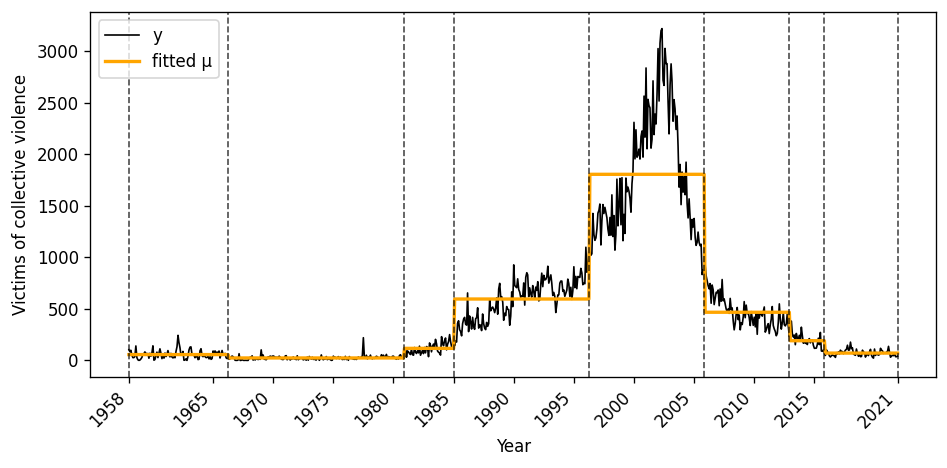

bkps with edges: [0, 45, 105, 275, 315, 385, 515, 550, 665, 695, 768]
alpha≈ 1.4649 | pen= 6.644


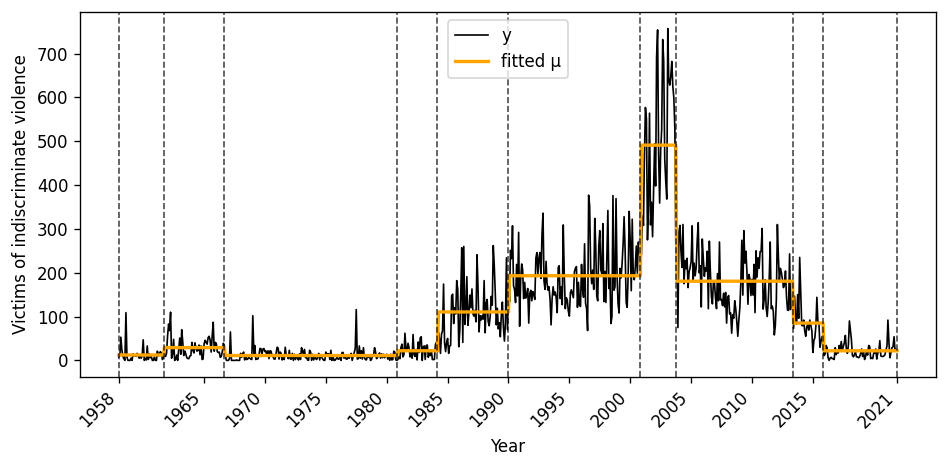

bkps with edges: [0, 95, 230, 275, 335, 460, 570, 610, 685, 768]
alpha≈ 2.3187 | pen= 6.644


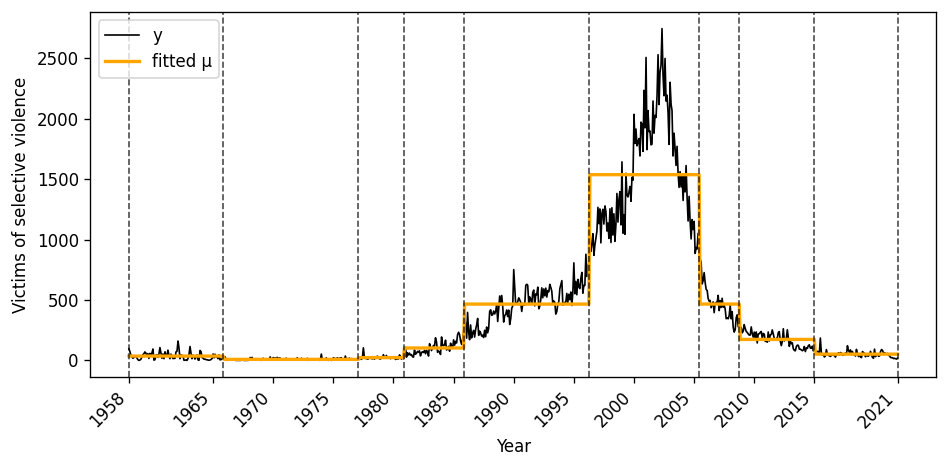

bkps with edges: [0, 100, 220, 275, 325, 360, 460, 580, 685, 768]
alpha≈ 2.0573 | pen= 6.644


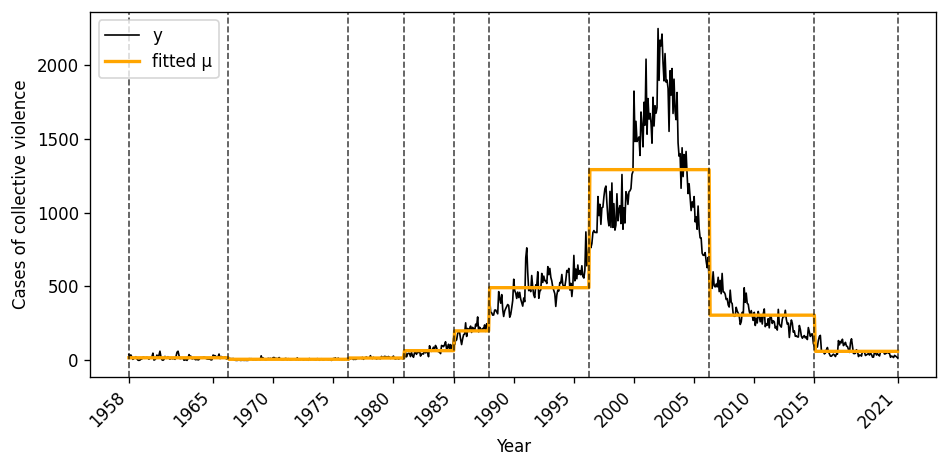

bkps with edges: [0, 45, 105, 130, 275, 330, 385, 515, 665, 725, 768]
alpha≈ 1.4043 | pen= 6.644


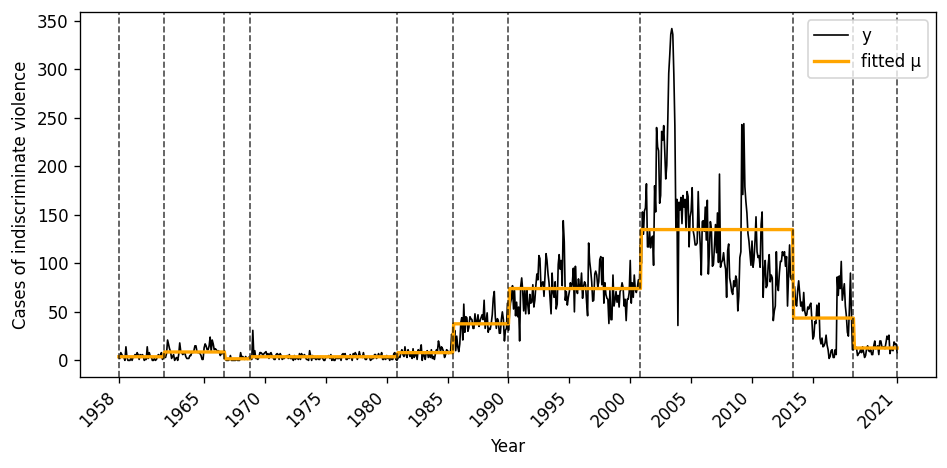

bkps with edges: [0, 95, 225, 275, 315, 360, 460, 570, 610, 690, 768]
alpha≈ 2.3139 | pen= 6.644


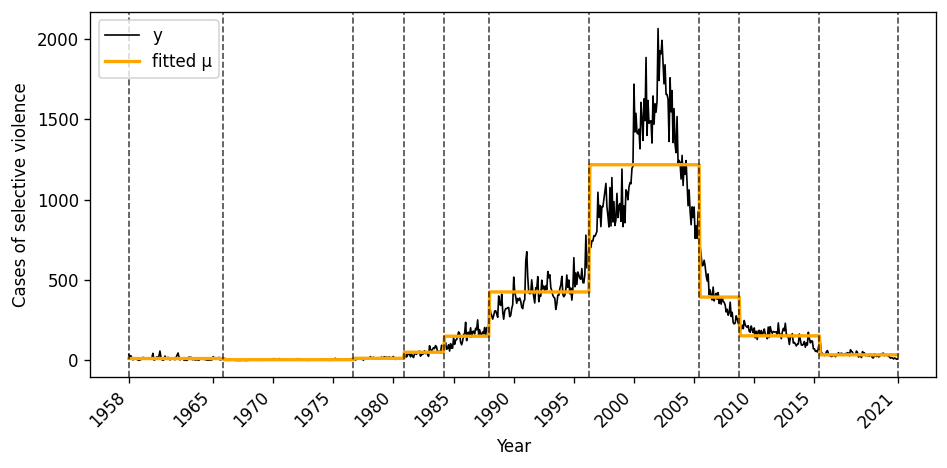

In [ ]:
# 1) Run PELT
datesOrig = dfDataOrig['period'].values.tolist()
dates = pd.to_datetime(dfDataOrig['period'], format="%Y/%m").values.tolist()
segmentsViolences = {}

idIndicatorViolenceList = [
    'Victims of collective violence','Victims of indiscriminate violence','Victims of selective violence',
    'Cases of collective violence','Cases of indiscriminate violence','Cases of selective violence']

modelSegmentation = "nb_const" # "nb_const", "nb_glm_linear", "nb_glm_linear_pop"

fullSummaryBreakPoints = []
for idIndicatorViolence in idIndicatorViolenceList:
  y = np.array(dfDataOrig[idIndicatorViolence].values.tolist())
  if modelSegmentation== "nb_const":
    bkps_with_edges, info = run_pelt_nb(y, model="nb_const", min_size=25, penalty="bic")
  elif modelSegmentation== "nb_glm_linear":
    bkps_with_edges, info = run_pelt_nb(y, model="nb_glm_linear", min_size=25, penalty="bic")
  elif modelSegmentation== "nb_glm_linear_pop":
    bkps_with_edges, info = run_pelt_nb(y, model="nb_glm_linear_pop", min_size=25, penalty="bic",
                                        df_monthly=df_monthly, pop_col="population", pop_log=True, pop_standardize=True)

  print("bkps with edges:", bkps_with_edges)   # includes 0 and T
  print("alpha≈", round(info["alpha"], 4), "| pen=", round(info["penalty"], 3))

  # 2) Store per-segment parameters (as list and DataFrame)
  seg_list, seg_df = segment_params_summary(y, bkps_with_edges, model=info["model"], alpha=info["alpha"],df_monthly=df_monthly)
  # seg_df.to_csv("segment_params.csv", index=False)   # save for later if you want

  ticks = compute_time_ticks(dates[0], dates[-1], year_interval=5, include_edges=True)

  plot_series_with_bkps_and_fit(
      y, bkps_with_edges, model=info["model"], alpha=info["alpha"],
      title="",
      dates=dates, ticks=ticks, tick_fmt="%Y",label_y_axis = idIndicatorViolence,
      tick_font_size = 10,
      figsize=(8,4),
      df_monthly=df_monthly
  )
  fullSummaryBreakPoints.append([idIndicatorViolence,seg_list])

  segmentList = []
  for sl in seg_list:
    dateStart = (datesOrig[sl['start']])
    dateEnd = (datesOrig[sl['end']-1])
    date_fmt = pd.to_datetime(dateStart, format="%Y/%m")
    dateStart = date_fmt.strftime("%Y-%m-%d")
    date_fmt = pd.to_datetime(dateEnd, format="%Y/%m")
    dateEnd = date_fmt.strftime("%Y-%m-%d")
    segmentList.append((dateStart,dateEnd))
    segmentsViolences[idIndicatorViolence] = segmentList

segmentsViolences = dict(reversed(list(segmentsViolences.items())))

In [ ]:
import re
import pandas as pd
from pathlib import Path
from typing import List, Any

def _sanitize_sheet_name(name: str, used: set[str]) -> str:
    """Ajusta nombre para Excel: sin caracteres prohibidos y máx. 31 chars, único."""
    # Reemplaza caracteres no permitidos en Excel
    cleaned = re.sub(r'[\\/*?:\[\]]', '_', str(name))
    # Recorta a 31 chars
    base = cleaned[:31] or "Sheet"
    sheet = base
    i = 1
    # Evita duplicados
    while sheet in used:
        # deja espacio para sufijo (_2, _3, …)
        suffix = f"_{i}"
        room = 31 - len(suffix)
        sheet = (base[:room] if room > 0 else "S") + suffix
        i += 1
    used.add(sheet)
    return sheet

def save_segments_list_to_excel(data: List[List[Any]], out_path: str = "segments.xlsx") -> Path:
    """
    data: lista de listas con la forma:
      [
        [<nombre_indicador>, [ {seg:.., start:.., ...}, {..}, ... ]],
        [<nombre_indicador_2>, [ {...}, ... ]],
        ...
      ]
    out_path: ruta de salida .xlsx
    """
    # 1) Aplana a una tabla larga
    rows = []
    for item in data:
        if not isinstance(item, (list, tuple)) or len(item) != 2:
            continue  # salta entradas mal formadas
        indicator, seg_list = item
        if not isinstance(seg_list, (list, tuple)):
            continue
        for seg_dict in seg_list:
            if isinstance(seg_dict, dict):
                row = {"indicator": indicator}
                row.update(seg_dict)
                rows.append(row)

    if not rows:
        raise ValueError("No se encontraron filas válidas en la lista.")

    df_all = pd.DataFrame(rows)

    # 2) Orden sugerido de columnas (las que existan)
    col_order = ["indicator", "seg", "start", "end", "length", "model",
                 "mu", "beta0", "beta1", "beta_pop"]
    cols = [c for c in col_order if c in df_all.columns] + \
           [c for c in df_all.columns if c not in col_order]
    df_all = df_all[cols]

    # 3) Escribe Excel: una hoja con todo y hojas por indicador
    out_path = Path(out_path)
    used_names = set()
    with pd.ExcelWriter(out_path) as writer:
        # Hoja completa
        df_all.to_excel(writer, sheet_name=_sanitize_sheet_name("all_segments", used_names), index=False)

        # Hojas por indicador
        for indicator, df_ind in df_all.groupby("indicator", sort=False):
            sheet = _sanitize_sheet_name(str(indicator), used_names)
            df_ind.to_excel(writer, sheet_name=sheet, index=False)

    return out_path

# ============================
# USO
# ============================
# Pega tu lista tal cual en la variable 'data'
data = fullSummaryBreakPoints

# Guardar
outfile = save_segments_list_to_excel(data, out_path="/content/drive/My Drive/ViolenceSegmentation/segments_info_"+str(modelSegmentation)+".xlsx")
print(f"Archivo Excel guardado en: {outfile.resolve()}")


Archivo Excel guardado en: /content/drive/My Drive/ViolenceSegmentation/segments_info_nb_const.xlsx


In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

data = segmentsViolences

# Pastel palette
palette = [
    "rgba(155,135,245,0.75)",
    "rgba(245,180,180,0.75)",
    "rgba(255,200,120,0.75)",
    "rgba(180,230,200,0.75)",
    "rgba(140,220,230,0.75)",
]

# ---------- Helpers ----------
def _td_from_days(days_arr):
    """Convert days (float or array) to numpy timedelta64[ns]."""
    ns = np.rint(np.asarray(days_arr, dtype=float) * 24 * 3600 * 1e9).astype("int64")
    return ns.astype("timedelta64[ns]")

def _fmt_year_month(x):
    """Return 'YYYY/MM' for any date-like input."""
    return pd.to_datetime(x).strftime("%Y/%m")

def _cap_centers(x0, x1, *, rx_days_base: float, rx_min_days: float, rx_max_days: float):
    """
    Compute the centers of the left/right rounded caps and the effective rx (in days).
    Returns (left_c, right_c, rx_days) as numpy.datetime64 for centers.
    """
    x0_dt = np.datetime64(pd.to_datetime(x0))
    x1_dt = np.datetime64(pd.to_datetime(x1))
    span_days = (x1_dt - x0_dt).astype("timedelta64[D]").astype(float)

    rx_days = float(np.clip(rx_days_base, rx_min_days, rx_max_days))
    rx_days = min(rx_days, span_days / 2.0)

    rx_td = _td_from_days(rx_days)
    left_c  = x0_dt + rx_td
    right_c = x1_dt - rx_td
    return left_c, right_c, rx_days

def add_center_annotation_date(fig, x0, x1, y, text=None, font_size=11, color="black",min_years_for_text=6):
    """Place an annotation at the temporal midpoint of [x0, x1] on a date axis."""
    s = pd.to_datetime(x0)
    e = pd.to_datetime(x1)
    x_center = (s + (e - s) / 2).to_pydatetime()  # Python datetime (required for date axis)
    if text is None:
        text = f"{s:%Y/%m} – {e:%Y/%m}"

    months = (e.year - s.year) * 12 + (e.month - s.month)
    if months < 12 * min_years_for_text:
      text = ""

    fig.add_annotation(
        x=x_center, y=float(y),
        xref="x", yref="y",
        text=text,
        showarrow=False,
        xanchor="center", yanchor="middle",
        align="center",
        font=dict(size=font_size, color=color),
    )

# ---------- Drawing ----------
def rounded_bar_polygon(
    fig, x0, x1, y, *,
    height: float = 0.6,
    rx_days_base: float = 60.0,
    rx_min_days: float = 3,
    rx_max_days: float = 400,
    color: str = "rgba(255,200,120,0.75)"
) -> go.Scatter:
    """
    Draw a rounded rectangle between [x0, x1] at level y on a DATE axis.
    All X values are emitted as Python datetimes to ensure correct date handling.
    """
    left_c, right_c, rx_days = _cap_centers(
        x0, x1, rx_days_base=rx_days_base, rx_min_days=rx_min_days, rx_max_days=rx_max_days
    )
    ry = height / 2.0

    def _to_py_dt(arr):
        return [pd.to_datetime(v).to_pydatetime() for v in np.asarray(arr)]

    # Straight edges
    x_top = _to_py_dt(np.array([left_c, right_c]))
    y_top = [y + ry, y + ry]
    x_bottom = _to_py_dt(np.array([right_c, left_c]))
    y_bottom = [y - ry, y - ry]

    # Rounded tips (semicircles)
    th_r = np.linspace(np.pi/2, -np.pi/2, 48)
    th_l = np.linspace(-np.pi/2,  np.pi/2, 48)
    xr_dt64 = right_c + _td_from_days(rx_days * np.cos(th_r))
    xl_dt64 = left_c  - _td_from_days(rx_days * np.cos(th_l))
    xr = _to_py_dt(xr_dt64)
    xl = _to_py_dt(xl_dt64)
    yr = (y + ry * np.sin(th_r)).tolist()
    yl = (y + ry * np.sin(th_l)).tolist()

    # Assemble polygon path
    xs = x_top + xr + x_bottom + xl
    ys = y_top + yr + y_bottom + yl

    trace = go.Scatter(
        x=xs, y=ys, mode="lines",
        line=dict(width=0),
        fill="toself", fillcolor=color,
        hoverinfo="skip", showlegend=False
    )
    fig.add_trace(trace)
    return trace

# ---------- Compute common radius base ----------
all_spans_days = []
for periods in data.values():
    for s, e in periods:
        s = pd.to_datetime(s); e = pd.to_datetime(e)
        all_spans_days.append((e - s).days)

longest_span_days = max(all_spans_days) if all_spans_days else 0
rx_frac_of_longest = 0.06  # 6% of longest span
rx_days_base = longest_span_days * rx_frac_of_longest

# ---------- Build figure ----------
fig = go.Figure()
rows = list(data.keys())
ypos = np.arange(len(rows))

for i, (row, periods) in enumerate(data.items()):
    color = palette[i % len(palette)]
    for (start, end) in periods:
        rounded_bar_polygon(
            fig, start, end, y=ypos[i], height=0.6,
            rx_days_base=rx_days_base, rx_min_days=5, rx_max_days=400, color=color
        )
        add_center_annotation_date(
            fig, start, end, y=ypos[i],
            text=f"{pd.to_datetime(start):%Y/%m} – {pd.to_datetime(end):%Y/%m}",
            font_size=9, color="black"
        )

# ---------- Axes & layout ----------
starts = pd.to_datetime([s for ps in data.values() for (s, _) in ps]) if data else pd.to_datetime([])
ends   = pd.to_datetime([e for ps in data.values() for (_, e) in ps]) if data else pd.to_datetime([])

# X range padding
if len(starts) and len(ends):
    x_min = (starts.min() - pd.Timedelta(days=30)).to_pydatetime()
    x_max = (ends.max()   + pd.Timedelta(days=30)).to_pydatetime()
else:
    x_min, x_max = None, None

# Ticks every 5 years (M60) anchored to a 5-year boundary
if len(starts):
    first_year = starts.min().year
    anchor_year = (first_year // 5) * 5
    tick0 = pd.Timestamp(year=anchor_year, month=1, day=1).to_pydatetime()
else:
    tick0 = None  # Plotly will pick a default

fig.update_xaxes(
    type="date",
    range=[x_min, x_max] if x_min and x_max else None,
    dtick="M60",                # every 60 months = 5 years
    tick0=tick0,                # anchor to a 5-year boundary
    tickformat="%Y",            # show only the year
    side="top",
    showgrid=False,
    title=None
)

fig.update_yaxes(
    tickvals=ypos, ticktext=rows,
    range=[-0.8, len(rows) - 0.2],
    showgrid=False, title=None
)

fig.update_layout(
    title="",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=160, r=40, t=60, b=40),
    height=max(300, 80 + 28 * len(rows))
)

fig.show()

/tmp/ipython-input-1391399364.py:84: UserWarning:

Discarding nonzero nanoseconds in conversion.

